# Transform Consistency Loss

In [112]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map, se3_exp_map
# from functorch import jacfwd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [113]:
device

device(type='cuda', index=0)

## Extrinsic Representations

We need to work in at least 3 representations of extrinsic matrices for this problem.

1. Rigid body transforms in $SE(3)$ tangent space are represented as a `transform` matrix
2. Rotation matrices in $SO(3)$ tangent space translation vectors are represented as a `pose` tuple
3. The 6 degrees of freedom are represented as a vector of `params`

These are all isomorphisms, and below we define functions for converting between these different representations.

In [114]:
def transform_from_params(params):
    return se3_exp_map(params).mT

In [115]:
def params_from_transform(transform):
    return se3_log_map(transform.mT)

In [116]:
def pose_from_transform(transform):
    return transform[..., :3, :3], transform[..., :3,[3]]

## Data Loader

A good dataloader should read files from the disk and not use too much memory.

Unfortunately, the large dataset that Oli supplied is compressed in `npz` format, and must be uncompressed first before it can be used. Our strategy will be to load the file, then write it out as a temporary `memmap`'d file which can be indexed without needing to read the whole file into memory.

In [117]:
class CarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        print(self.K)
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_0 = torch.from_numpy(self.rgbs[idx+0].copy()).permute(2, 0, 1) / 255
        image_q = torch.from_numpy(self.rgbs[idx+1].copy()).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()).permute(2, 0, 1) / 255
        # Our depth images i
        depth_0 = torch.from_numpy(self.depths[idx+0].copy() * 1000)
        depth_q = torch.from_numpy(self.depths[idx+1].copy() * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy() * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z -> -z, x, y
        axes = torch.tensor([
            [0, 0,-1, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ]).double()
        
        # Our poses
        extrinsic_0 = torch.from_numpy(self.transforms[idx+0]) @ axes
        extrinsic_q = torch.from_numpy(self.transforms[idx+1]) @ axes
        extrinsic_1 = torch.from_numpy(self.transforms[idx+2]) @ axes
        
        transform_0q = torch.linalg.inv(extrinsic_0) @ extrinsic_q
        transform_1q = torch.linalg.inv(extrinsic_1) @ extrinsic_q
        transform_10 = torch.linalg.inv(extrinsic_1) @ extrinsic_0
        
        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        def resize(x):
            # return x
            # return torchvision.transforms.functional.resize(x, (450, 600), antialias=True)
            # # torchvision.transforms.Compose(torchvision.transforms.CenterCrop)
            # return torchvision.transforms.functional.resize(x, (300, 400), antialias=True)
            
            return torchvision.transforms.functional.resize(x, (225, 300), antialias=True)
            # return x[..., 0:200, 50:350]
            # return  x[..., 0:200, 50:350]
        
        return (
            self.K.unsqueeze(0),
            resize(image_q),
            resize(image_0),
            resize(image_1),
            resize(depth_q.unsqueeze(0)).squeeze(),
            resize(depth_0.unsqueeze(0)).squeeze(),
            resize(depth_1.unsqueeze(0)).squeeze(),
            transform_0q.float(),
            transform_1q.float(),
            transform_10.float(),
        )
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01

In [118]:
class CarlaTriplesDataset_baseline5(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        print(self.K)
        self.K[0] = self.K[0] / 800
        self.K[1] = self.K[1] / 600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_0 = torch.from_numpy(self.rgbs[idx+0].copy()).permute(2, 0, 1) / 255
        image_q = torch.from_numpy(self.rgbs[idx+4].copy()).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+9].copy()).permute(2, 0, 1) / 255
        # Our depth images i
        depth_0 = torch.from_numpy(self.depths[idx+0].copy() * 1000)
        depth_q = torch.from_numpy(self.depths[idx+4].copy() * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+9].copy() * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z -> -z, x, y
        axes = torch.tensor([
            [0, 0,-1, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ]).double()
        
        # Our poses
        extrinsic_0 = torch.from_numpy(self.transforms[idx+0]) @ axes
        extrinsic_q = torch.from_numpy(self.transforms[idx+4]) @ axes
        extrinsic_1 = torch.from_numpy(self.transforms[idx+9]) @ axes
        
        transform_0q = torch.linalg.inv(extrinsic_0) @ extrinsic_q
        transform_1q = torch.linalg.inv(extrinsic_1) @ extrinsic_q
        transform_10 = torch.linalg.inv(extrinsic_1) @ extrinsic_0
        
        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        def resize(x):
            # return x
            # return torchvision.transforms.functional.resize(x, (450, 600), antialias=True)
            # # torchvision.transforms.Compose(torchvision.transforms.CenterCrop)
            # return torchvision.transforms.functional.resize(x, (300, 400), antialias=True)
            
            return torchvision.transforms.functional.resize(x, (225, 300), antialias=True)
            # return x[..., 0:200, 50:350]
            # return  x[..., 0:200, 50:350]
        
        return (
            self.K.unsqueeze(0),
            resize(image_q),
            resize(image_0),
            resize(image_1),
            resize(depth_q.unsqueeze(0)).squeeze(),
            resize(depth_0.unsqueeze(0)).squeeze(),
            resize(depth_1.unsqueeze(0)).squeeze(),
            transform_0q.float(),
            transform_1q.float(),
            transform_10.float(),
        )
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01

## Perspective Geometry

In [119]:
def apply_transform(points, transform):
    """
    Project points to camera reference frame
    """
    R, t = transform[..., :3, :3], transform[..., :3, [3]]
    return R @ points + t

In [120]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [121]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [122]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [123]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [124]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [125]:
def grid_sample(image, flow):
    """
    Hacky implementation of torch.nn.functional.grid_sample,
    created so that the derivative can be computed with jacfwd.
    """
    N, C, IH, IW = image.shape
    _, H, W, _ = flow.shape

    ix = flow[..., 0]
    iy = flow[..., 1]

    ix = ((ix + 1) / 2) * (IW-1);
    iy = ((iy + 1) / 2) * (IH-1);
    
    with torch.no_grad():
        ix_nw = torch.floor(ix);
        iy_nw = torch.floor(iy);
        ix_ne = ix_nw + 1;
        iy_ne = iy_nw;
        ix_sw = ix_nw;
        iy_sw = iy_nw + 1;
        ix_se = ix_nw + 1;
        iy_se = iy_nw + 1;

    nw = (ix_se - ix)    * (iy_se - iy)
    ne = (ix    - ix_sw) * (iy_sw - iy)
    sw = (ix_ne - ix)    * (iy    - iy_ne)
    se = (ix    - ix_nw) * (iy    - iy_nw)

    with torch.no_grad():
        ix_nw = torch.clamp(ix_nw, 0, IW-1)
        iy_nw = torch.clamp(iy_nw, 0, IH-1)
        ix_ne = torch.clamp(ix_ne, 0, IW-1)
        iy_ne = torch.clamp(iy_ne, 0, IH-1)
        ix_sw = torch.clamp(ix_sw, 0, IW-1)
        iy_sw = torch.clamp(iy_sw, 0, IH-1)
        ix_se = torch.clamp(ix_se, 0, IW-1)
        iy_se = torch.clamp(iy_se, 0, IH-1)

    image = image.view(N, C, IH * IW)

    nw_val = torch.gather(image, 2, (iy_nw * IW + ix_nw).long().view(N, 1, H * W).repeat(1, C, 1))
    ne_val = torch.gather(image, 2, (iy_ne * IW + ix_ne).long().view(N, 1, H * W).repeat(1, C, 1))
    sw_val = torch.gather(image, 2, (iy_sw * IW + ix_sw).long().view(N, 1, H * W).repeat(1, C, 1))
    se_val = torch.gather(image, 2, (iy_se * IW + ix_se).long().view(N, 1, H * W).repeat(1, C, 1))

    return (
        nw_val.view(N, C, H, W) * nw.view(N, 1, H, W) +    
        ne_val.view(N, C, H, W) * ne.view(N, 1, H, W) +       
        sw_val.view(N, C, H, W) * sw.view(N, 1, H, W) +
        se_val.view(N, C, H, W) * se.view(N, 1, H, W)
    )

In [126]:
def resample(depth, K, transform, target):
    """
    Backproject a depth map with K and transform it into a new reference frame T.
    Sample colors from the target image.
    """

    points_3d = backproject(depth, K)
    points_3d = apply_transform(points_3d, transform)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    return grid_sample(target, points_2d)

## Gauss-Newton

In [127]:
class GaussNewtonFeatureOptimizer(torch.nn.Module):
    
    def __init__(self, K, features, saliency, depth):
        super().__init__()
        self.K = K
        self.features = features
        self.saliency = saliency
        self.depth = depth
        self.residuals_grad = torch.func.jacfwd(self.residuals)

    def residuals(self, params, features, saliency):
        transform = transform_from_params(params).unsqueeze(1)
        resampled = resample(self.depth.double(), self.K.double(), transform.double(), features.double())
        resampled_saliency = resample(self.depth.double(), self.K.double(), transform.double(), saliency.double())
        # residuals = self.features - resampled

        residuals = torch.nn.HuberLoss(reduction='none', delta = 0.2)(self.features.float() - resampled.float(),torch.zeros(self.features.shape).to(device)).reshape(features.shape)
        # residuals = self.saliency * resampled_saliency *(self.features - resampled)
        residuals = self.saliency * resampled_saliency*residuals
        residuals = residuals[...,0:190,20:205]
        return residuals.ravel()
    
    def update_step(self, params, features, saliency):
        r = self.residuals(params, features, saliency)
        J = self.residuals_grad(params, features, saliency).squeeze()
        H = J.mT @ J + 1e-6 * torch.eye(6, device=J.device)
        return torch.linalg.lstsq(H, J.mT @ -r).solution
    
    def solve(self, params, features, saliency, iterations):
        output = params.unsqueeze(0)
        for i in range(iterations):
            update = self.update_step(output.detach(), features, saliency).unsqueeze(0)
            output = params_from_transform(
                transform_from_params(output) @
                transform_from_params(update)
            )
        return output

    def forward(self, batch, features, saliency, iterations=30):
        # TODO: Try to use VMap for batching
        output = batch.clone()
        for i, params in enumerate(batch):
            output[i] = self.solve(params, features, saliency, iterations)
        return output

## Loss Functions

## Transform Consistency Loss

Looking carefully at the definition of Transform Consistency Loss:

$$
L_{\mathrm{c}}\left(T_{q, r_0}^*, T_{q, r_1}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1}\left(T_{q, r_1}^k\right)^{-1} T_{q, r_0}^*\right)\right\|_1 .
$$

Transform Consistency Loss depends on taking the logarithm of a SE(3) matrix. However, SE(3) matrices have negative numbers that we need to deal with.

To compute the logairthm, we will use the function `se3_log_map` from PyTorch3D. As PyTorch3D is a pain to install, I have just copied the code into `se3.py`.

In [128]:
def transform_consistency_loss(T_q0, T_q1, T_01):
    T_1q = torch.linalg.inv(T_q1)
    transform_consistency = T_01.to(T_q0.device) @ T_1q @ T_q0
    return torch.linalg.norm(se3_log_map(transform_consistency.mT))

## Transform Accuracy Loss

This is essentially a sanity check using ground truth data that we have available.

$$
L_{\mathrm{a}}\left(T_{r_1, r_0}^k\right)=\left\|\log \left(\hat{T}_{r_0, r_1} T_{r_1, r_0}^k\right)\right\|_1
$$

In [129]:
def transform_accuracy_loss(T_hat, T_inv_est):
    transform_accuracy = T_hat @ T_inv_est.to(T_hat.device)
    return torch.linalg.norm(se3_log_map(transform_accuracy.mT))

## Data Loader

In [130]:
# memmap_test = load_data_as_memmap('data-2023-03-29-test.npz', tempfile.mkdtemp())
test_rain_dynamics = CarlaTriplesDataset(np.load("testset/test_rain_dynamics_417.npz")) 
test_rain_nodynamics = CarlaTriplesDataset(np.load("testset/test_rain_noDynamics_417.npz"))
test_sunny_dynamics = CarlaTriplesDataset(np.load("testset/test_sunny_dynamics_417.npz"))
test_sunny_nodynamics = CarlaTriplesDataset(np.load("testset/test_sunny_noDynamics_417.npz"))
# test_rain_dynamics = CarlaTriplesDataset(np.load("test_rain_dynamics_0424.npz"))
# test_rain_nodynamics = CarlaTriplesDataset(np.load("test_rain_noDynamics_0424.npz"))
# test_sunny_dynamics = CarlaTriplesDataset(np.load("test_sunny_dynamics_0424.npz"))
# test_sunny_nodynamics = CarlaTriplesDataset(np.load("test_sunny_noDynamics_0424.npz"))

tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])


In [131]:
dataloader_rain_dynamics = torch.utils.data.DataLoader(test_rain_dynamics, batch_size=1, shuffle=False)
dataloader_rain_nodynamics = torch.utils.data.DataLoader(test_rain_nodynamics, batch_size=1, shuffle=False)
dataloader_sunny_dynamics = torch.utils.data.DataLoader(test_sunny_dynamics, batch_size=1, shuffle=False)
dataloader_sunny_nodynamics = torch.utils.data.DataLoader(test_sunny_nodynamics, batch_size=1, shuffle=False)

In [88]:
test_rain_dynamics_baseline5 = CarlaTriplesDataset_baseline5(np.load("test_rain_dynamics_0424.npz"))
test_rain_nodynamics_baseline5 = CarlaTriplesDataset_baseline5(np.load("test_rain_noDynamics_0424.npz"))
test_sunny_dynamics_baseline5 = CarlaTriplesDataset_baseline5(np.load("test_sunny_dynamics_0424.npz"))
test_sunny_nodynamics_baseline5 = CarlaTriplesDataset_baseline5(np.load("test_sunny_noDynamics_0424.npz"))
from torch.utils.data import Subset

test_rain_dynamics_baseline5 = Subset(test_rain_dynamics_baseline5, np.arange(len(test_rain_dynamics_baseline5)-10))
test_rain_nodynamics_baseline5 = Subset(test_rain_nodynamics_baseline5, np.arange(len(test_rain_nodynamics_baseline5)-10))
test_sunny_dynamics_baseline5 = Subset(test_sunny_dynamics_baseline5, np.arange(len(test_sunny_dynamics_baseline5)-10))
test_sunny_nodynamics_baseline5 = Subset(test_sunny_nodynamics_baseline5, np.arange(len(test_sunny_nodynamics_baseline5)-10))

dataloader_rain_dynamics_baseline5 = torch.utils.data.DataLoader(test_rain_dynamics_baseline5, batch_size=1, shuffle=False)
dataloader_rain_nodynamics_baseline5 = torch.utils.data.DataLoader(test_rain_nodynamics_baseline5, batch_size=1, shuffle=False)
dataloader_sunny_dynamics_baseline5 = torch.utils.data.DataLoader(test_sunny_dynamics_baseline5, batch_size=1, shuffle=False)
dataloader_sunny_nodynamics_baseline5 = torch.utils.data.DataLoader(test_sunny_nodynamics_baseline5, batch_size=1, shuffle=False)

tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])


### Show Example Images

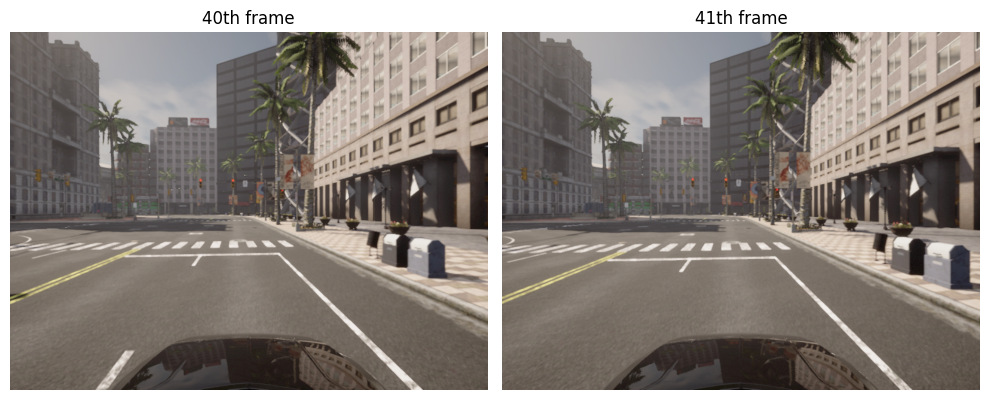

In [31]:
sunn_nd_npz = np.load("data_noDynamics_sunny_404.npz")
image1 = sunn_nd_npz['rgbs'][40]
image2 = sunn_nd_npz['rgbs'][41]
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set_title("40th frame")
ax[1].set_title("41th frame")
fig.tight_layout()
plt.savefig("report/baseline.png", bbox_inches='tight')


## Testing block

In [35]:
net = UNet(3, 17).to(device)
net_NS = UNet(3, 17).to(device)
# saliency map one:
# net.load_state_dict(torch.load("checkpoints/train_7_14_nosaliency.pth"))
# net_NS.load_state_dict(torch.load("checkpoints/train_7_14_nosaliency.pth"))

In [36]:
optimizer = torch.optim.Adam([
    {'params': net.parameters(), 'lr': 1e-4},
    # {'params': damping, 'lr': 5e-4},
])

In [37]:
def featuresSaliency(image, net):
    pyramid = net.forward(image)
    features, saliency = pyramid[-1]
    return features, saliency

 Error Function


In [132]:
def errors(transform_0q_est,transform_0q):
    error = params_from_transform(torch.linalg.inv(transform_0q_est.double()) @ transform_0q.double())
    translation_error = torch.linalg.norm(error[0, 0:3])
    rotation_error = torch.linalg.norm(error[0, 3:6])
    
    return translation_error, rotation_error

In [133]:
def test(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10):
    # result_0q = torch.zeros(len(K.double()), 6, device=device) # params_from_transform(transform_q0) # 
    result_0q = torch.zeros(len(K), 6, device=device)
    with torch.no_grad():
        pyramid_q = net.forward(image_q.to(device))
        pyramid_0 = net.forward(image_0.to(device))
    levels = [0, 1, 2, 3]
    iterations = [16, 12, 8, 4]
    for level in levels:
        features_q, saliency_q = pyramid_q[level]
        features_0, saliency_0 = pyramid_0[level]
            
        # Resample depth maps for pyramid
        size = features_q.shape[-2:]
        depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

        # Align image_0 to query image
        image_0_optimizer = GaussNewtonFeatureOptimizer(K.double(), features_0.double(), saliency_0.double(), depth_0_.double())
        result_0q = image_0_optimizer.forward(result_0q.double(), features_q.double(), saliency_q.double(), iterations=iterations[level])
        
        # print(result_0q)
        # image_0_optimizer = GaussNewtonFeatureOptimizer(K, features_0, saliency_0, depth_0_)
        # result_0q = image_0_optimizer.forward(result_0q.float(), features_q.float(), saliency_q.float(), iterations[level])
    transform_0q_est = transform_from_params(result_0q.double())
    # transform_0q_est = transform_from_params(result_0q)
    rotation_error, translation_error = errors(transform_0q_est, transform_0q)

    return rotation_error, translation_error

In [134]:
def test_dataloader(dataloader):
    progress = tqdm.tqdm(dataloader)
    translation_error_list = np.zeros(len(dataloader))
    rotation_error_list = np.zeros(len(dataloader))
    for batch_idx, batch in enumerate(progress):
        K, image_q, image_0, image_1, depth_q, depth_0, depth_1,  transform_0q, transform_1q, transform_10 = (
            x.to(device)
            for x in batch
        )
        rotation_error, translation_error = test(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10)
        translation_error_list[batch_idx] = translation_error.item()
        rotation_error_list[batch_idx] = rotation_error.item()
    max_10_translation_error = np.argsort(translation_error_list)[-10:]
    max_10_rotation_error = np.argsort(rotation_error_list)[-10:]
    mean_translation_error = np.mean(translation_error_list)
    mean_rotation_error = np.mean(rotation_error_list)
    var_translation_error = np.var(translation_error_list)
    var_rotation_error = np.var(rotation_error_list)
    # max_translation_error_images = [image_q[max_10_translation_error], image_0[max_10_translation_error], image_1[max_10_translation_error]]
    # max_rotation_error_images = [image_q[max_10_rotation_error], image_0[max_10_rotation_error], image_1[max_10_rotation_error]]
    # return translation_error_list, rotation_error_list, np.mean(translation_error_list), np.mean(rotation_error_list),max_10_translation_error, max_10_rotation_error
    return mean_translation_error, mean_rotation_error, var_translation_error, var_rotation_error, translation_error_list, rotation_error_list
    

Using SIFT

In [106]:
import cv2
def orb_match(query_image,reference_image,K):
    query_gray = grayImage = cv2.cvtColor(query_image.reshape(225,300), cv2.COLOR_GRAY2BGR)
    # ref_gray = reference_image.reshape(225,300).astype('uint8')
    ref_gray = grayImage = cv2.cvtColor(reference_image.reshape(225,300), cv2.COLOR_GRAY2BGR)

    orb = cv2.ORB_create(nfeatures=10000)

    # Detect keypoints and compute descriptors for both images
    query_kp, query_desc = orb.detectAndCompute(query_gray, None)
    ref_kp, ref_desc = orb.detectAndCompute(ref_gray, None)

    # print("query_kp", len(query_kp))
    # print("ref_kp", len(ref_kp))

    # Initialize the matcher (Brute-Force Hamming)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors
    matches = matcher.match(query_desc, ref_desc)
    # print("matches", len(matches))

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)[:30]

    if len(matches) > 10:
        src_pts = np.float32([query_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([ref_kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        # matches_mask = mask.ravel().tolist()
        # print("M.shape", M.shape)
        num, Rs, Ts, Ns  = cv2.decomposeHomographyMat(M, K)
        # print("ts", Ts)
        # print("rs", Rs)
        # make them into 4x4 matrix
        # print("Rs[0]", Rs[0].shape)
        # print("Ts[0]", Ts[0].shape)
        transform = np.zeros((4,4))
        transform[:3,:3] = Rs[0]
        transform[:3,3] = Ts[0][:,0]
        return transform
    else:
        print("Not enough matches are found - {}/{}".format(len(matches), 10))
        matches_mask = None
        return None

In [107]:
def test_dataloader_sift(dataloader):
    progress = tqdm.tqdm(dataloader)
    translation_error_list = np.zeros(len(dataloader))
    rotation_error_list = np.zeros(len(dataloader))
    for batch_idx, batch in enumerate(progress):
        K, image_q, image_0, image_1, depth_q, depth_0, depth_1,  transform_0q, transform_1q, transform_10 = (
            x.to(device)
            for x in batch
        )
        # turn image tensors into images
        image_q = image_q.squeeze(0).permute(1,2,0).cpu().numpy()
        image_0 = image_0.squeeze(0).permute(1,2,0).cpu().numpy()
        #grey scale
        image_q = cv2.cvtColor(image_q, cv2.COLOR_BGR2GRAY)
        image_0 = cv2.cvtColor(image_0, cv2.COLOR_BGR2GRAY)
        # transformation,_ = sift_matching(image_q, image_0)
        transformation = orb_match (image_0,image_q,K.cpu().numpy())
        if transformation is not None:
            # print("transofrm_0q", transform_0q.shape, type(transform_0q))
            # print("transform_0q", transform_0q)
            # print("transformation", transformation)
            translation_error, rotation_error = errors(transform_0q, torch.Tensor(transformation).unsqueeze(0).to(device))
            translation_error_list[batch_idx] = translation_error.item()
            rotation_error_list[batch_idx] = rotation_error.item()
    return translation_error_list, rotation_error_list
    

In [108]:
# sunny no dynamics
# snd_mean_translation_error, snd_mean_rotation_error, snd_var_translation_error, snd_var_rotation_error, snd_translation_error_list, snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
# all_snd_translation_error_list, all_snd_rotation_error_list = test_dataloader_sift(dataloader_sunny_nodynamics)
# sunny dynamics
# sd_mean_translation_error, sd_mean_rotation_error, sd_var_translation_error, sd_var_rotation_error, sd_translation_error_list, sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
all_sd_translation_error_list, all_sd_rotation_error_list = test_dataloader_sift(dataloader_sunny_dynamics)
# rainy no dynamics
# rnd_mean_translation_error, rnd_mean_rotation_error, rnd_var_translation_error, rnd_var_rotation_error, rnd_translation_error_list, rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
all_rnd_translation_error_list, all_rnd_rotation_error_list = test_dataloader_sift(dataloader_rain_nodynamics)
# rainy dynamics
# rd_mean_translation_error, rd_mean_rotation_error, rd_var_translation_error, rd_var_rotation_error, rd_translation_error_list, rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)
all_rd_translation_error_list, all_rd_rotation_error_list = test_dataloader_sift(dataloader_rain_dynamics)

100%|██████████| 48/48 [00:08<00:00,  5.49it/s]


In [109]:
np.mean(all_snd_translation_error_list),np.mean(all_sd_translation_error_list),np.mean(all_rnd_translation_error_list),np.mean(all_rd_translation_error_list)

(0.09604734301146327, 112.26579065338755, 4048.975889863055, 4855.440915335889)

Baseline about 5m, compare to posenet pumpkin scene 

In [110]:
# net.load_state_dict(torch.load("checkpoints/fyp_test_final/checkpoint24.pth"))


# sunny no dynamics
# snd_mean_translation_error, snd_mean_rotation_error, snd_var_translation_error, snd_var_rotation_error, snd_translation_error_list, snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
_,_,_,_,all_snd_translation_error_list_baseline5, all_snd_rotation_error_list_baseline5 = test_dataloader(dataloader_sunny_nodynamics_baseline5)
# sunny dynamics
# sd_mean_translation_error, sd_mean_rotation_error, sd_var_translation_error, sd_var_rotation_error, sd_translation_error_list, sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
_,_,_,_,all_sd_translation_error_list_baseline5, all_sd_rotation_error_list_baseline5 = test_dataloader(dataloader_sunny_dynamics_baseline5)
# rainy no dynamics
# rnd_mean_translation_error, rnd_mean_rotation_error, rnd_var_translation_error, rnd_var_rotation_error, rnd_translation_error_list, rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
_,_,_,_,all_rnd_translation_error_list_baseline5, all_rnd_rotation_error_list_baseline5 = test_dataloader(dataloader_rain_nodynamics_baseline5)
# rainy dynamics
# rd_mean_translation_error, rd_mean_rotation_error, rd_var_translation_error, rd_var_rotation_error, rd_translation_error_list, rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)
_,_,_,_,all_rd_translation_error_list_baseline5, all_rd_rotation_error_list_baseline5 = test_dataloader(dataloader_rain_dynamics_baseline5)

  0%|          | 0/28 [00:00<?, ?it/s]c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torch\nn\functional.py:3233: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::huber_loss_backward. Please file us an issue on G

In [111]:
total_all_translation_errors_baseline5 = np.concatenate((all_snd_translation_error_list_baseline5, all_sd_translation_error_list_baseline5, all_rnd_translation_error_list_baseline5, all_rd_translation_error_list_baseline5))
total_all_rotation_errors_baseline5 = np.concatenate((all_snd_rotation_error_list_baseline5, all_sd_rotation_error_list_baseline5, all_rnd_rotation_error_list_baseline5, all_rd_rotation_error_list_baseline5))
mean_translation_errors_baseline5 = np.mean(total_all_translation_errors_baseline5)
mean_rotation_errors_baseline5 = np.mean(total_all_rotation_errors_baseline5)
print("mean_translation_errors: ", mean_translation_errors_baseline5)
print("mean_rotation_errors: ", mean_rotation_errors_baseline5)

# variance 
var_trans_errors_baseline5 = np.var(total_all_translation_errors_baseline5)
var_rot_errors_baseline5 = np.var(total_all_rotation_errors_baseline5)
print("var_trans_errors", var_trans_errors_baseline5)
print("var_rot_errors", var_rot_errors_baseline5)

mean_translation_errors:  0.05695772704813254
mean_rotation_errors:  2.672892736395571
var_trans_errors 0.002772231046469358
var_rot_errors 1.4557633513860069


With Saliency Map

In [118]:
net.load_state_dict(torch.load("checkpoints/fyp_test_final/checkpoint24.pth"))

<All keys matched successfully>

In [119]:
# sunny no dynamics
# snd_mean_translation_error, snd_mean_rotation_error, snd_var_translation_error, snd_var_rotation_error, snd_translation_error_list, snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
all_snd_mean_translation_error, all_snd_mean_rotation_error, all_snd_var_translation_error, all_snd_var_rotation_error, all_snd_translation_error_list, all_snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
# sunny dynamics
# sd_mean_translation_error, sd_mean_rotation_error, sd_var_translation_error, sd_var_rotation_error, sd_translation_error_list, sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
all_sd_mean_translation_error, all_sd_mean_rotation_error, all_sd_var_translation_error, all_sd_var_rotation_error, all_sd_translation_error_list, all_sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
# rainy no dynamics
# rnd_mean_translation_error, rnd_mean_rotation_error, rnd_var_translation_error, rnd_var_rotation_error, rnd_translation_error_list, rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
all_rnd_mean_translation_error, all_rnd_mean_rotation_error, all_rnd_var_translation_error, all_rnd_var_rotation_error, all_rnd_translation_error_list, all_rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
# rainy dynamics
# rd_mean_translation_error, rd_mean_rotation_error, rd_var_translation_error, rd_var_rotation_error, rd_translation_error_list, rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)
all_rd_mean_translation_error, all_rd_mean_rotation_error, all_rd_var_translation_error, all_rd_var_rotation_error, all_rd_translation_error_list, all_rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)

  0%|          | 0/38 [00:00<?, ?it/s]c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torch\nn\functional.py:3233: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::huber_loss_backward. Please file us an issue on G

In [70]:
# append all errors
# all_translation_errors = np.concatenate((snd_translation_error_list, sd_translation_error_list, rnd_translation_error_list, rd_translation_error_list))
# all_rotation_errors = np.concatenate((snd_rotation_error_list, sd_rotation_error_list, rnd_rotation_error_list, rd_rotation_error_list))
total_all_translation_errors = np.concatenate((all_snd_translation_error_list, all_sd_translation_error_list, all_rnd_translation_error_list, all_rd_translation_error_list))
total_all_rotation_errors = np.concatenate((all_snd_rotation_error_list, all_sd_rotation_error_list, all_rnd_rotation_error_list, all_rd_rotation_error_list))
mean_translation_errors = np.mean(total_all_translation_errors)
mean_rotation_errors = np.mean(total_all_rotation_errors)
print("mean_translation_errors: ", mean_translation_errors)
print("mean_rotation_errors: ", mean_rotation_errors)

# variance 
var_trans_errors = np.var(total_all_translation_errors)
var_rot_errors = np.var(total_all_rotation_errors)
print("var_trans_errors", var_trans_errors)
print("var_rot_errors", var_rot_errors)

mean_translation_errors:  0.0048372014563293035
mean_rotation_errors:  0.18145962396183324
var_trans_errors 3.982130526397488e-05
var_rot_errors 0.031788149978435626


In [120]:
# save to npz
# np.savez_compressed("25epoch_test.npz", snd_translation = all_snd_translation_error_list, snd_rotation= all_snd_rotation_error_list, 
# sd_translation = all_sd_translation_error_list, sd_rotation= all_sd_rotation_error_list,
#  rnd_translation = all_rnd_translation_error_list, rnd_rotation= all_rnd_rotation_error_list, 
#  rd_translation = all_rd_translation_error_list, rd_rotation= all_rd_rotation_error_list)

Means: [0.0024698187572075037, 0.004868350164186964, 0.003184507958309089, 0.005914987354448994]
Variances: [1.5274228035284882e-06, 6.4063921900992765e-06, 4.236684458570529e-06, 1.0078880544428106e-05]
Standard Deviations: [0.001235889478686702, 0.0025310851803325932, 0.0020583207861192407, 0.0031747252707010894]


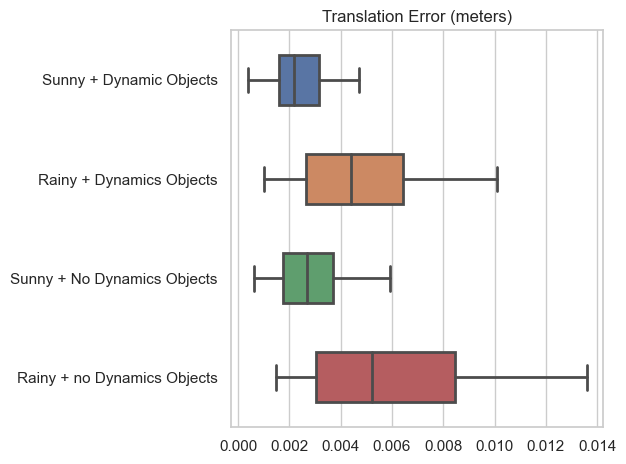

In [121]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_translation_error_list,  rd_translation_error_list, snd_translation_error_list,rnd_translation_error_list]
data = [all_sd_translation_error_list,  all_rd_translation_error_list, all_snd_translation_error_list,all_rnd_translation_error_list]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False, whis=1.2)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
# ax.set_xlim(0, 0.025)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Translation Error (meters)')
plt.tight_layout()
# plt.savefig('report/translation_error_saliency_2.png')
# plt.savefig('report/final_translation_error_3.png')
plt.show()


Means: [0.10135465338361738, 0.12083996394866696, 0.1525150718831625, 0.12614434012126774]
Variances: [0.0025925448703193843, 0.0049979678514307365, 0.011753419684686454, 0.005325012870923579]
Standard Deviations: [0.050917039096155074, 0.07069630719797701, 0.10841318962509337, 0.07297268578669405]


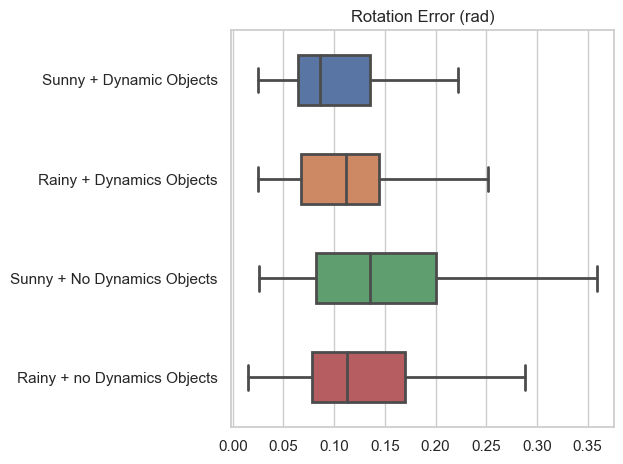

In [134]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_rotation_error_list,  rd_rotation_error_list, snd_rotation_error_list,rnd_rotation_error_list]
data = [all_sd_rotation_error_list,  all_rd_rotation_error_list, all_snd_rotation_error_list,all_rnd_rotation_error_list]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
# ax.set_xlim(0, 1.4)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Rotation Error (rad)')
plt.tight_layout()
# plt.savefig('report/rotation_error_saliency_2.png')
# plt.savefig('report/final_rotation_error_3.png')
plt.show()


Without huber, but have saliency map

In [123]:
net.load_state_dict(torch.load('checkpoints/fyp_test_final/test_checkpoints/saliency_noHuber/checkpoint9.pth')) # has saliency, not huber
# snd_mean_translation_error, snd_mean_rotation_error, snd_var_translation_error, snd_var_rotation_error, snd_translation_error_list, snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
# # sunny dynamics
# sd_mean_translation_error, sd_mean_rotation_error, sd_var_translation_error, sd_var_rotation_error, sd_translation_error_list, sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
# # rainy no dynamics
# rnd_mean_translation_error, rnd_mean_rotation_error, rnd_var_translation_error, rnd_var_rotation_error, rnd_translation_error_list, rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
# # rainy dynamics
# rd_mean_translation_error, rd_mean_rotation_error, rd_var_translation_error, rd_var_rotation_error, rd_translation_error_list, rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)


noHuber_snd_mean_translation_error, noHuber_snd_mean_rotation_error, noHuber_snd_var_translation_error, noHuber_snd_var_rotation_error, noHuber_snd_translation_error_list, noHuber_snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
# sunny dynamics
noHuber_sd_mean_translation_error, noHuber_sd_mean_rotation_error, noHuber_sd_var_translation_error, noHuber_sd_var_rotation_error, noHuber_sd_translation_error_list, noHuber_sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
# rainy no dynamics
noHuber_rnd_mean_translation_error, noHuber_rnd_mean_rotation_error, noHuber_rnd_var_translation_error, noHuber_rnd_var_rotation_error, noHuber_rnd_translation_error_list, noHuber_rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
# rainy dynamics
noHuber_rd_mean_translation_error, noHuber_rd_mean_rotation_error, noHuber_rd_var_translation_error, noHuber_rd_var_rotation_error, noHuber_rd_translation_error_list, noHuber_rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)

  0%|          | 0/38 [00:00<?, ?it/s]c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torch\nn\functional.py:3233: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::huber_loss_backward. Please file us an issue on G

Means: [0.02430368137224644, 0.04466676529144497, 0.03728846088099659, 0.05327940367792451]
Variances: [0.0004700112098617215, 0.00476471891347094, 0.0005589957732253059, 0.003016674474109153]
Standard Deviations: [0.02167974192331914, 0.0690269433878608, 0.023643091448144127, 0.05492426125228407]


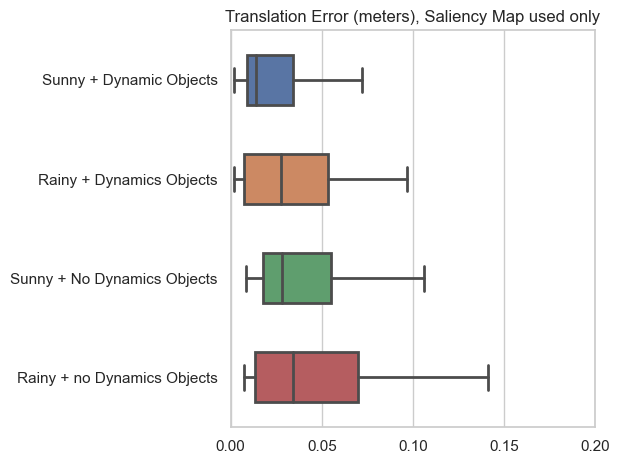

In [126]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_translation_error_list,  rd_translation_error_list, snd_translation_error_list,rnd_translation_error_list]
data = [noHuber_sd_translation_error_list,  noHuber_rd_translation_error_list, noHuber_snd_translation_error_list,noHuber_rnd_translation_error_list]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
ax.set_xlim(0, 0.2)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Translation Error (meters), Saliency Map used only')
plt.tight_layout()
# plt.savefig('report/ablation_noHuber_t_2.png')
# plt.savefig('report/final_ablation_noHuber_t_3.png')
plt.show()


Means: [0.559130663969139, 0.530339722686665, 0.7132371817156647, 0.692679158713944]
Variances: [0.08754640167082635, 0.10743217060467014, 0.06539379155708464, 0.05966451142425124]
Standard Deviations: [0.29588241189842013, 0.327768471035074, 0.25572209829634324, 0.24426320112585775]


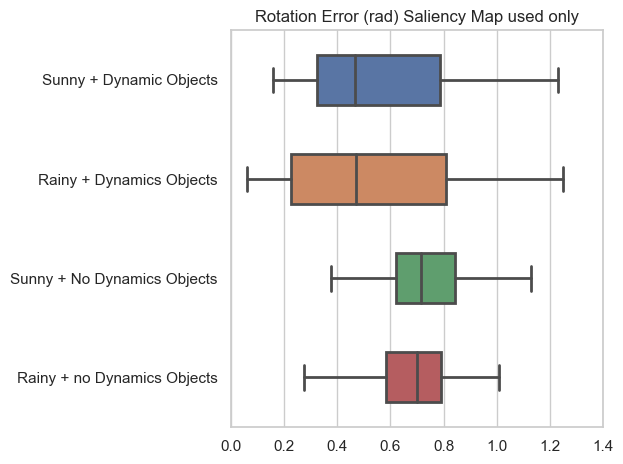

In [127]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_rotation_error_list,  rd_rotation_error_list, snd_rotation_error_list,rnd_rotation_error_list]
data = [noHuber_sd_rotation_error_list,  noHuber_rd_rotation_error_list, noHuber_snd_rotation_error_list,noHuber_rnd_rotation_error_list]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
ax.set_xlim(0, 1.4)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Rotation Error (rad) Saliency Map used only')
plt.tight_layout()
# plt.savefig('report/ablation_noHuber_r_2.png')
# plt.savefig('report/final_ablation_noHuber_r_3.png')
plt.show()


In [68]:
# total_mean_trans = np.mean([snd_mean_translation_error, sd_mean_translation_error, rnd_mean_translation_error, rd_mean_translation_error])
# total_mean_rot = np.mean([snd_mean_rotation_error, sd_mean_rotation_error, rnd_mean_rotation_error, rd_mean_rotation_error])
total_noHuber_mean_trans = np.mean([noHuber_snd_mean_translation_error, noHuber_sd_mean_translation_error, noHuber_rnd_mean_translation_error, noHuber_rd_mean_translation_error])
total_noHuber_mean_rot = np.mean([noHuber_snd_mean_rotation_error, noHuber_sd_mean_rotation_error, noHuber_rnd_mean_rotation_error, noHuber_rd_mean_rotation_error])
print("total_mean_trans",total_noHuber_mean_trans)
print("total_mean_rot",total_noHuber_mean_rot)
# varience 
total_noHuber_var_trans = np.mean([noHuber_snd_var_translation_error, noHuber_sd_var_translation_error, noHuber_rnd_var_translation_error, noHuber_rd_var_translation_error])
total_noHuber_var_rot = np.mean([noHuber_snd_var_rotation_error, noHuber_sd_var_rotation_error, noHuber_rnd_var_rotation_error, noHuber_rd_var_rotation_error])
print("total_var_trans", total_noHuber_var_trans)
print("total_var_rot", total_noHuber_var_rot)

total_mean_trans 0.041442780107362895
total_mean_rot 0.6164228860324028
total_var_trans 0.0025519759844763153
total_var_rot 0.09680140827363477


In [88]:
np.savez_compressed("ablation_saliency_test.npz", snd_translation= noHuber_snd_translation_error_list, sd_translation= noHuber_sd_translation_error_list, rnd_translation= noHuber_rnd_translation_error_list, rd_translation= noHuber_rd_translation_error_list, snd_rotation= noHuber_snd_rotation_error_list, sd_rotation= noHuber_sd_rotation_error_list, rnd_rotation= noHuber_rnd_rotation_error_list, rd_rotation= noHuber_rd_rotation_error_list)

Without Saleincy, but have Huber

In [128]:
# net.load_state_dict(torch.load('checkpoints/train_7_9.pth'))
net.load_state_dict(torch.load('checkpoints/fyp_test_final/test_checkpoints/huber_noSaliency/checkpoint9.pth'))
snd_mean_translation_error, snd_mean_rotation_error, snd_var_translation_error, snd_var_rotation_error, snd_translation_error_list, snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
# sunny dynamics
sd_mean_translation_error, sd_mean_rotation_error, sd_var_translation_error, sd_var_rotation_error, sd_translation_error_list, sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
# rainy no dynamics
rnd_mean_translation_error, rnd_mean_rotation_error, rnd_var_translation_error, rnd_var_rotation_error, rnd_translation_error_list, rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
# rainy dynamics
rd_mean_translation_error, rd_mean_rotation_error, rd_var_translation_error, rd_var_rotation_error, rd_translation_error_list, rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)


  0%|          | 0/38 [00:00<?, ?it/s]c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\28340\anaconda3\envs\tcl\lib\site-packages\torch\nn\functional.py:3233: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::huber_loss_backward. Please file us an issue on G

Means: [0.002821171096981784, 0.00616052986860816, 0.0037002129412983796, 0.007886245714181948]
Variances: [3.5990014476415055e-06, 1.2111520916516277e-05, 1.1034961341945177e-05, 3.8919473079454596e-05]
Standard Deviations: [0.0018971034361999098, 0.0034801610474971237, 0.0033218912296981034, 0.0062385473533070656]


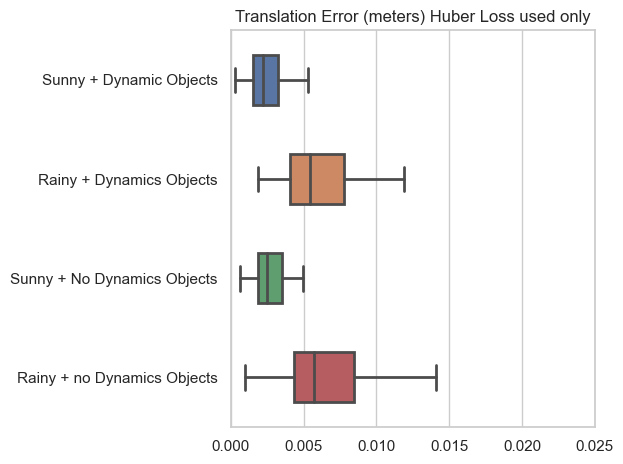

In [129]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
data = [sd_translation_error_list,  rd_translation_error_list, snd_translation_error_list,rnd_translation_error_list]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
ax.set_xlim(0, 0.025)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Translation Error (meters) Huber Loss used only')
plt.tight_layout()
# plt.savefig('report/ablation_noSaliency_t_2.png')
# plt.savefig('report/ablation_noSaliency_t_3.png')
plt.show()


Means: [0.14005442119541314, 0.1845166414589511, 0.17199917970490364, 0.17705304393245125]
Variances: [0.00721616698152443, 0.04550630326077784, 0.018107533945021355, 0.025366481113252598]
Standard Deviations: [0.08494802517730728, 0.21332206463649708, 0.13456423724385821, 0.15926858168908456]


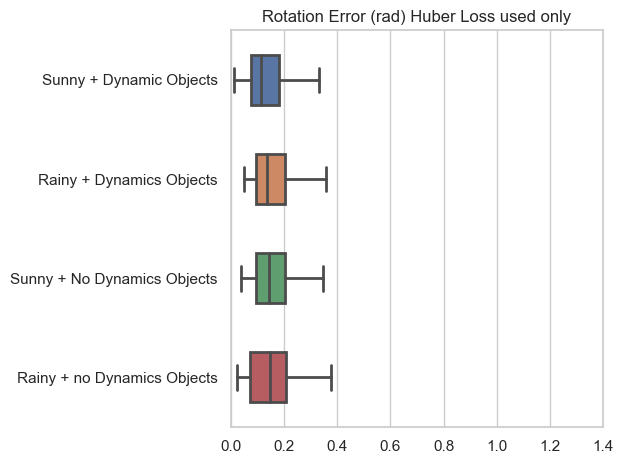

In [130]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
data = [sd_rotation_error_list,  rd_rotation_error_list, snd_rotation_error_list,rnd_rotation_error_list]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
ax.set_xlim(0, 1.4)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
# plt.title('Rotation Error (rad) without Salieny Map')
plt.title('Rotation Error (rad) Huber Loss used only')
plt.tight_layout()
# plt.savefig('report/ablation_noSaliency_r_2.png')
# plt.savefig('report/ablation_noSaliency_r_3.png')
plt.show()


In [132]:
total_mean_trans = np.mean([snd_mean_translation_error, sd_mean_translation_error, rnd_mean_translation_error, rd_mean_translation_error])
total_mean_rot = np.mean([snd_mean_rotation_error, sd_mean_rotation_error, rnd_mean_rotation_error, rd_mean_rotation_error])
print("total_mean_trans",total_mean_trans)
print("total_mean_rot",total_mean_rot)
# varience
total_var_trans = np.mean([snd_var_translation_error, sd_var_translation_error, rnd_var_translation_error, rd_var_translation_error])
total_var_rot = np.mean([snd_var_rotation_error, sd_var_rotation_error, rnd_var_rotation_error, rd_var_rotation_error])
print("total_var_trans",total_var_trans)
print("total_var_rot",total_var_rot)

total_mean_trans 0.005142039905267568
total_mean_rot 0.16840582157292977
total_var_trans 1.641623919638939e-05
total_var_rot 0.024049121325144057


In [133]:
# np.savez_compressed("ablation_huber_test.npz",sd_translation_error_list=sd_translation_error_list,rd_translation_error_list=rd_translation_error_list,snd_translation_error_list=snd_translation_error_list,rnd_translation_error_list=rnd_translation_error_list,sd_rotation_error_list=sd_rotation_error_list,rd_rotation_error_list=rd_rotation_error_list,snd_rotation_error_list=snd_rotation_error_list,rnd_rotation_error_list=rnd_rotation_error_list)

Feature maps & Saliency map

In [138]:
# net.load_state_dict(torch.load('checkpoints/train_7_9.pth'))
net.load_state_dict(torch.load('checkpoints/fyp_test_final/checkpoint9.pth'))
snd_mean_translation_error_10, snd_mean_rotation_error_10, snd_var_translation_error_10, snd_var_rotation_error_10, snd_translation_error_list_10, snd_rotation_error_list_10 = test_dataloader(dataloader_sunny_nodynamics)
# sunny dynamics
sd_mean_translation_error_10, sd_mean_rotation_error_10, sd_var_translation_error_10, sd_var_rotation_error_10, sd_translation_error_list_10, sd_rotation_error_list_10 = test_dataloader(dataloader_sunny_dynamics)
# rainy no dynamics
rnd_mean_translation_error_10, rnd_mean_rotation_error_10, rnd_var_translation_error_10, rnd_var_rotation_error_10, rnd_translation_error_list_10, rnd_rotation_error_list_10 = test_dataloader(dataloader_rain_nodynamics)
# rainy dynamics
rd_mean_translation_error_10, rd_mean_rotation_error_10, rd_var_translation_error_10, rd_var_rotation_error_10, rd_translation_error_list_10, rd_rotation_error_list_10 = test_dataloader(dataloader_rain_dynamics)


100%|██████████| 98/98 [03:52<00:00,  2.37s/it]


Means: [0.003685607840517432, 0.005474900982937699, 0.004679117454946358, 0.008689002109176744]
Variances: [4.13623575071677e-06, 1.017141656293312e-05, 4.8542791742277964e-05, 0.00017955318644698344]
Standard Deviations: [0.0020337737707810007, 0.0031892658344724292, 0.006967265729271273, 0.013399745760535289]


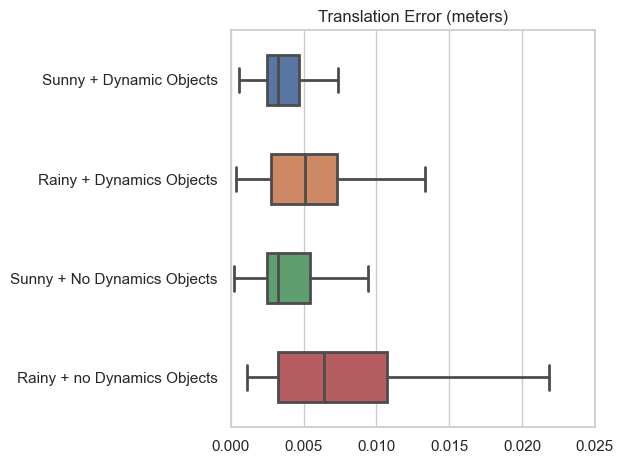

In [139]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
data = [sd_translation_error_list_10,  rd_translation_error_list_10, snd_translation_error_list_10,rnd_translation_error_list_10]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
ax.set_xlim(0, 0.025)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Translation Error (meters)')
plt.tight_layout()
# plt.savefig('report/ablation_all_10_t_3.png')
plt.show()


Means: [0.2191471679105587, 0.12462158590756371, 0.19185933412992573, 0.21304422529576697]
Variances: [0.0223568099844538, 0.004909956875632127, 0.019269336485868302, 0.04308350818258229]
Standard Deviations: [0.1495219381376987, 0.07007108444738191, 0.1388140356227291, 0.20756567197535888]


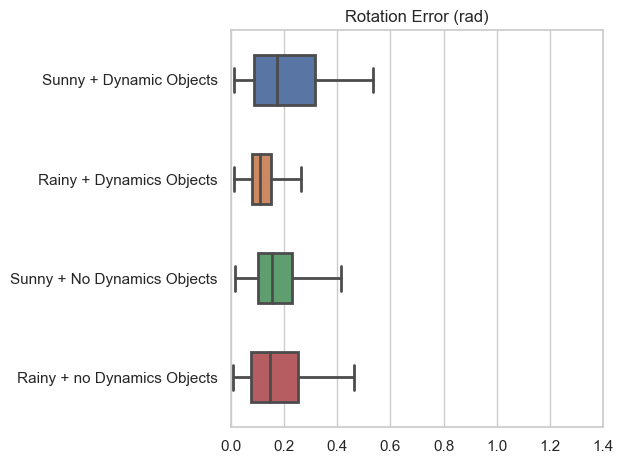

In [141]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
data = [sd_rotation_error_list_10,  rd_rotation_error_list_10, snd_rotation_error_list_10,rnd_rotation_error_list_10]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
ax.set_xlim(0, 1.4)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Rotation Error (rad)')
plt.tight_layout()
plt.savefig('report/ablation_all_10_r_3.png')
plt.show()


In [61]:
total_mean_trans = np.mean([snd_mean_translation_error_10, sd_mean_translation_error_10, rnd_mean_translation_error_10, rd_mean_translation_error_10])
total_mean_rot = np.mean([snd_mean_rotation_error, sd_mean_rotation_error, rnd_mean_rotation_error_10, rd_mean_rotation_error_10])
print("total_mean_trans",total_mean_trans)
print("total_mean_rot",total_mean_rot)

total_mean_trans 0.005632157096894558
total_mean_rot 0.19118014847179118


In [90]:
np.savez_compressed("ablation_full_10epoch.npz",sd_translation_error_list=sd_translation_error_list_10,rd_translation_error_list=rd_translation_error_list_10,snd_translation_error_list=snd_translation_error_list_10,rnd_translation_error_list=rnd_translation_error_list_10,sd_rotation_error_list=sd_rotation_error_list_10,rd_rotation_error_list=rd_rotation_error_list_10,snd_rotation_error_list=snd_rotation_error_list_10,rnd_rotation_error_list=rnd_rotation_error_list_10)

Epoch 10, no saliency, difference


In [135]:
net.load_state_dict(torch.load("checkpoints/fyp_test_final/checkpoint9.pth"))

<All keys matched successfully>

In [136]:
# sunny no dynamics
# snd_mean_translation_error, snd_mean_rotation_error, snd_var_translation_error, snd_var_rotation_error, snd_translation_error_list, snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
all_snd_mean_translation_error_noS, all_snd_mean_rotation_error_noS, all_snd_var_translation_error_noS, all_snd_var_rotation_error_noS, all_snd_translation_error_list_noS, all_snd_rotation_error_list_noS = test_dataloader(dataloader_sunny_nodynamics)
# sunny dynamics
# sd_mean_translation_error, sd_mean_rotation_error, sd_var_translation_error, sd_var_rotation_error, sd_translation_error_list, sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
all_sd_mean_translation_error_noS, all_sd_mean_rotation_error_noS, all_sd_var_translation_error_noS, all_sd_var_rotation_error_noS, all_sd_translation_error_list_noS, all_sd_rotation_error_list_noS = test_dataloader(dataloader_sunny_dynamics)
# rainy no dynamics
# rnd_mean_translation_error, rnd_mean_rotation_error, rnd_var_translation_error, rnd_var_rotation_error, rnd_translation_error_list, rnd_rotation_error_list = test_dataloader(dataloader_rain_nodynamics)
all_rnd_mean_translation_error_noS, all_rnd_mean_rotation_error_noS, all_rnd_var_translation_error_noS, all_rnd_var_rotation_error_noS, all_rnd_translation_error_list_noS, all_rnd_rotation_error_list_noS = test_dataloader(dataloader_rain_nodynamics)
# rainy dynamics
# rd_mean_translation_error, rd_mean_rotation_error, rd_var_translation_error, rd_var_rotation_error, rd_translation_error_list, rd_rotation_error_list = test_dataloader(dataloader_rain_dynamics)
all_rd_mean_translation_error_noS, all_rd_mean_rotation_error_noS, all_rd_var_translation_error_noS, all_rd_var_rotation_error_noS, all_rd_translation_error_list_noS, all_rd_rotation_error_list_noS = test_dataloader(dataloader_rain_dynamics)

 69%|██████▉   | 68/98 [02:58<01:18,  2.62s/it]


KeyboardInterrupt: 

In [144]:
# append all errors
# all_translation_errors = np.concatenate((snd_translation_error_list, sd_translation_error_list, rnd_translation_error_list, rd_translation_error_list))
# all_rotation_errors = np.concatenate((snd_rotation_error_list, sd_rotation_error_list, rnd_rotation_error_list, rd_rotation_error_list))
total_all_translation_errors_noS = np.concatenate((all_snd_translation_error_list_noS, all_sd_translation_error_list_noS, all_rnd_translation_error_list_noS, all_rd_translation_error_list_noS))
total_all_rotation_errors_noS = np.concatenate((all_snd_rotation_error_list_noS, all_sd_rotation_error_list_noS, all_rnd_rotation_error_list_noS, all_rd_rotation_error_list_noS))
mean_translation_errors_noS = np.mean(total_all_translation_errors_noS)
mean_rotation_errors_noS = np.mean(total_all_rotation_errors_noS)
print("mean_translation_errors: ", mean_translation_errors_noS)
print("mean_rotation_errors: ", mean_rotation_errors_noS)

# variance 
var_trans_errors_noS = np.var(total_all_translation_errors_noS)
var_rot_errors_noS = np.var(total_all_rotation_errors_noS)
print("var_trans_errors", var_trans_errors_noS)
print("var_rot_errors", var_rot_errors_noS)

mean_translation_errors:  0.0051382925742037315
mean_rotation_errors:  0.15905910992434605
var_trans_errors 8.531606456402507e-05
var_rot_errors 0.08230596394959482


Means: [0.0028574883864531855, 0.005179668273961571, 0.006628859295550078, 0.006476477627163961]
Variances: [1.8274401250136847e-06, 7.619828165523767e-06, 0.0003539355762027222, 9.712758617888312e-06]
Standard Deviations: [0.0013518284377145218, 0.002760403623661541, 0.01881317560123017, 0.0031165299000472163]


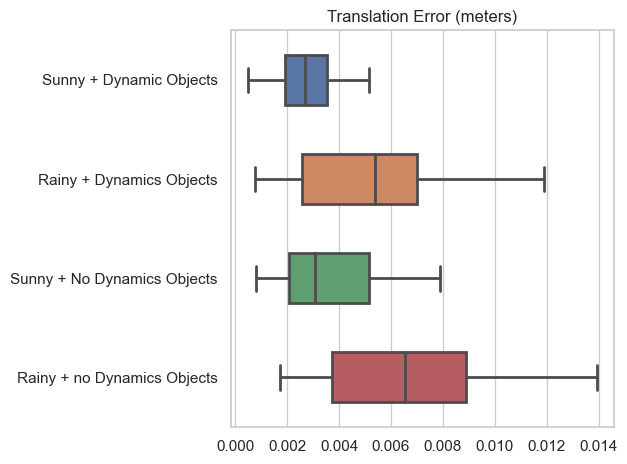

In [145]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_translation_error_list,  rd_translation_error_list, snd_translation_error_list,rnd_translation_error_list]
data = [all_sd_translation_error_list_noS,  all_rd_translation_error_list_noS, all_snd_translation_error_list_noS,all_rnd_translation_error_list_noS]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False, whis=1.2)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
ax.set_xlim(0, 0.025)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Translation Error (meters)')
plt.tight_layout()
# plt.savefig('report/translation_error_saliency_2.png')
# plt.savefig('report/final_translation_error_3.png')
plt.show()


Means: [0.11539081664093491, 0.13184471513765308, 0.2517824412374545, 0.15587180564715833]
Variances: [0.0034206535664542265, 0.006497614479447335, 0.33959526108434707, 0.008467144449828982]
Standard Deviations: [0.05848635367719744, 0.08060778175491083, 0.5827480253800497, 0.09201708781432383]


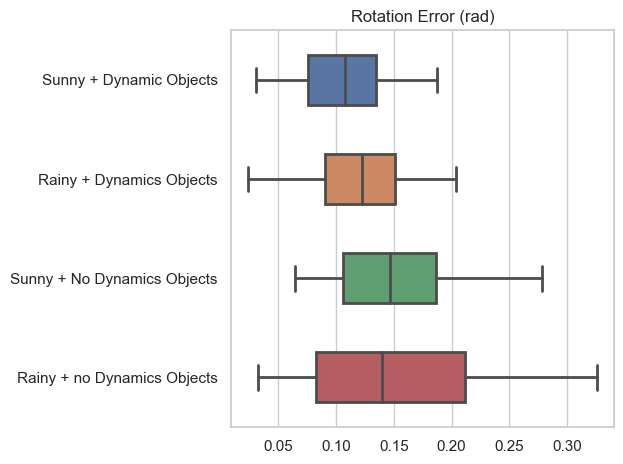

In [146]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_rotation_error_list,  rd_rotation_error_list, snd_rotation_error_list,rnd_rotation_error_list]
data = [all_sd_rotation_error_list_noS,  all_rd_rotation_error_list_noS, all_snd_rotation_error_list_noS,all_rnd_rotation_error_list_noS]
labels = ['Sunny + Dynamic Objects',  'Rainy + Dynamics Objects','Sunny + No Dynamics Objects', 'Rainy + no Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
# ax.set_xlim(0, 1.4)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Rotation Error (rad)')
plt.tight_layout()
# plt.savefig('report/rotation_error_saliency_2.png')
# plt.savefig('report/final_rotation_error_3.png')
plt.show()


## test use matched pairs

In [147]:
net.load_state_dict(torch.load("checkpoints/fyp_test_final/checkpoint24.pth"))
# sunny no dynamics


<All keys matched successfully>

In [150]:

test_sunny_dynamics_matched = CarlaTriplesDataset(np.load("test_ablation_sunny_dynamics_matched.npz"))
test_sunny_nodynamics_matched = CarlaTriplesDataset(np.load("test_ablation_sunny_nodynamics_matched.npz"))
dataloader_sunny_dynamics_matched = torch.utils.data.DataLoader(test_sunny_dynamics_matched, batch_size=1, shuffle=False)
dataloader_sunny_nodynamics_matched = torch.utils.data.DataLoader(test_sunny_nodynamics_matched, batch_size=1, shuffle=False)

tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])


In [158]:
# sunny no dynamics
# snd_mean_translation_error, snd_mean_rotation_error, snd_var_translation_error, snd_var_rotation_error, snd_translation_error_list, snd_rotation_error_list = test_dataloader(dataloader_sunny_nodynamics)
all_snd_mean_translation_error_matched, all_snd_mean_rotation_error_matched, all_snd_var_translation_error_matched, all_snd_var_rotation_error_matched, all_snd_translation_error_list_matched, all_snd_rotation_error_list_matched = test_dataloader(dataloader_sunny_nodynamics_matched)
# sunny dynamics
# sd_mean_translation_error, sd_mean_rotation_error, sd_var_translation_error, sd_var_rotation_error, sd_translation_error_list, sd_rotation_error_list = test_dataloader(dataloader_sunny_dynamics)
all_sd_mean_translation_error_matched, all_sd_mean_rotation_error_matched, all_sd_var_translation_error_matched, all_sd_var_rotation_error_matched, all_sd_translation_error_list_matched, all_sd_rotation_error_list_matched = test_dataloader(dataloader_sunny_dynamics_matched)


100%|██████████| 28/28 [00:58<00:00,  2.08s/it]


In [ ]:
# append all errors
# all_translation_errors = np.concatenate((snd_translation_error_list, sd_translation_error_list, rnd_translation_error_list, rd_translation_error_list))
# all_rotation_errors = np.concatenate((snd_rotation_error_list, sd_rotation_error_list, rnd_rotation_error_list, rd_rotation_error_list))
total_all_translation_errors_noS = np.concatenate((all_snd_translation_error_list_noS, all_sd_translation_error_list_noS, all_rnd_translation_error_list_noS, all_rd_translation_error_list_noS))
total_all_rotation_errors_noS = np.concatenate((all_snd_rotation_error_list_noS, all_sd_rotation_error_list_noS, all_rnd_rotation_error_list_noS, all_rd_rotation_error_list_noS))
mean_translation_errors_noS = np.mean(total_all_translation_errors_noS)
mean_rotation_errors_noS = np.mean(total_all_rotation_errors_noS)
print("mean_translation_errors: ", mean_translation_errors_noS)
print("mean_rotation_errors: ", mean_rotation_errors_noS)

# variance 
var_trans_errors_noS = np.var(total_all_translation_errors_noS)
var_rot_errors_noS = np.var(total_all_rotation_errors_noS)
print("var_trans_errors", var_trans_errors_noS)
print("var_rot_errors", var_rot_errors_noS)

mean_translation_errors:  0.0051382925742037315
mean_rotation_errors:  0.15905910992434605
var_trans_errors 8.531606456402507e-05
var_rot_errors 0.08230596394959482


Means: [0.004491066455570077, 0.003517308738273917]
Variances: [2.2724698377299416e-05, 4.940277983213688e-06]
Standard Deviations: [0.004767042938478677, 0.00222267361148993]


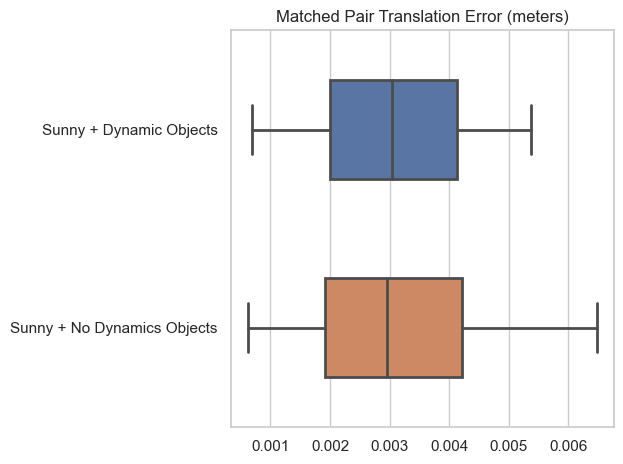

In [161]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_translation_error_list,  rd_translation_error_list, snd_translation_error_list,rnd_translation_error_list]
data = [all_sd_translation_error_list_matched,  all_snd_translation_error_list_matched]
labels = ['Sunny + Dynamic Objects',  'Sunny + No Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False, whis=1.2)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
# ax.set_xlim(0, 0.025)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Matched Pair Translation Error (meters)')
plt.tight_layout()
# plt.savefig('report/translation_error_saliency_2.png')
# plt.savefig('report/final_translation_error_3.png')
plt.show()


Means: [0.31610548610238237, 0.15769128745474323]
Variances: [0.18064363026664917, 0.013437418297618407]
Standard Deviations: [0.42502191739561995, 0.11591987878538523]


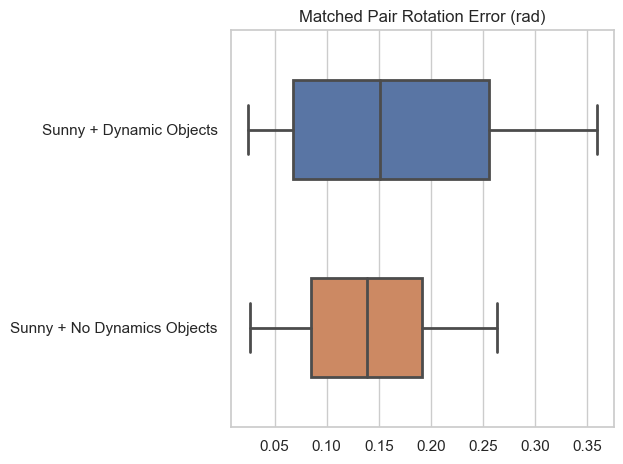

In [162]:
# box plot, sunny no dynamics, sunny dynamics, rainy no dynamics, rainy dynamics
# translation error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example error lists

# Combine the error lists
# data = [sd_rotation_error_list,  rd_rotation_error_list, snd_rotation_error_list,rnd_rotation_error_list]
data = [all_sd_rotation_error_list_matched, all_snd_rotation_error_list_matched]
labels = ['Sunny + Dynamic Objects', 'Sunny + No Dynamics Objects']

sns.set(style='whitegrid')
ax = sns.boxplot(data=data, width=0.5, linewidth=2, orient='h', showfliers=False)

# Customize box infills with different patterns
box_patterns = ['/', '.', '\\', '*']
for i, box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('none')
    box.set_hatch(box_patterns[i])

# Set the y-axis labels
ax.set_yticklabels(labels)
# ax.set_xlim(0, 1.4)
# Calculate means, variances, and standard deviations
means = [np.mean(error) for error in data]
variances = [np.var(error) for error in data]
stds = [np.std(error) for error in data]

# Print the statistics
print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", stds)

# Show the plot
plt.title('Matched Pair Rotation Error (rad)')
plt.tight_layout()
# plt.savefig('report/rotation_error_saliency_2.png')
# plt.savefig('report/final_rotation_error_3.png')
plt.show()


Saliency Epoch 25

In [92]:
net.load_state_dict(torch.load('checkpoints/train_7_24.pth'))

<All keys matched successfully>

In [93]:
def get_transforms(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10):
    result_0q = torch.zeros(len(K.double()), 6, device=device) # params_from_transform(transform_q0) # 

    with torch.no_grad():
        pyramid_q = net.forward(image_q.to(device))
        pyramid_0 = net.forward(image_0.to(device))
    levels = [0, 1, 2, 3]
    iterations = [16, 12, 8, 4]

    for level in levels:
        features_q, saliency_q = pyramid_q[level]
        features_0, saliency_0 = pyramid_0[level]
            
        # Resample depth maps for pyramid
        size = features_q.shape[-2:]
        depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

        # Align image_0 to query image
        image_0_optimizer = GaussNewtonFeatureOptimizer(K.double(), features_0.double(), saliency_0.double(), depth_0_.double())

        result_0q = image_0_optimizer.forward(result_0q.double(), features_q.double(), saliency_q.double(), iterations=iterations[level])
    
    transform_0q_est = transform_from_params(result_0q.double())
    test_result = errors(transform_0q_est, transform_0q)
    print("translation error:", test_result[0], "rotation error:", test_result[1])
    return transform_0q_est

In [106]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.unsqueeze(0).to(device)
    for x in test_sunny_dynamics[20])
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
#     x.unsqueeze(0).to(device)
#     for x in test_oli[0])
translation_est = get_transforms(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10)
resampled_image = resample(depth_q.double(), K.double(), torch.linalg.inv(translation_est.double()), image_q.double())

translation error: tensor(0.1517, device='cuda:0', dtype=torch.float64) rotation error: tensor(0.0066, device='cuda:0', dtype=torch.float64)


In [107]:
resample_gt = resample(depth_q.double(), K.double(),torch.linalg.inv(transform_0q.double()), image_q.double())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.0, 1.0, 0.0, 1.0)

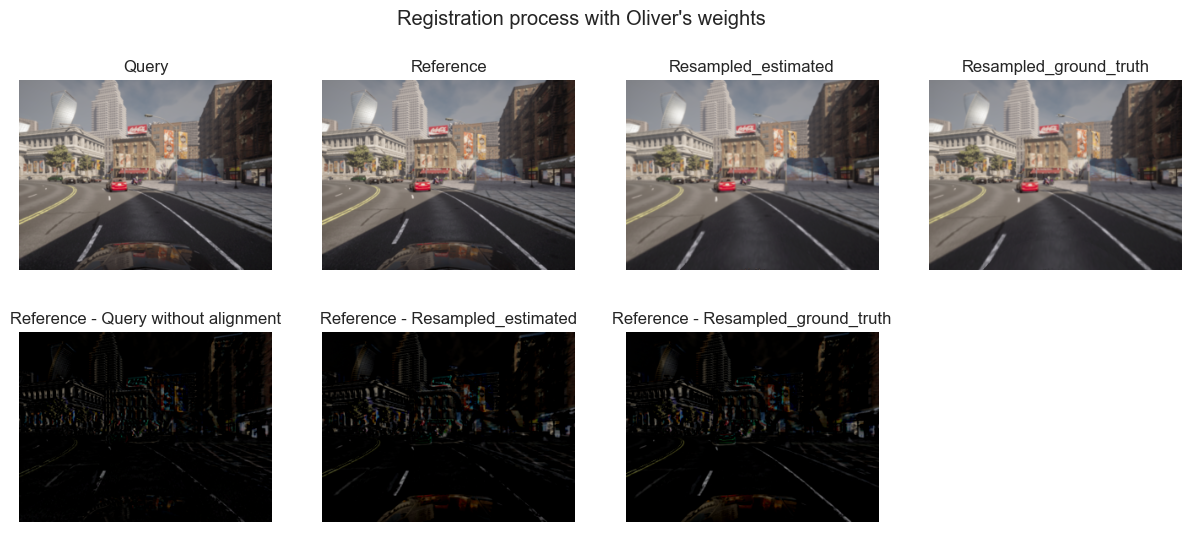

In [108]:
fig_single, ax_single = plt.subplots(2,4, figsize=(15,6))
fig_single.suptitle('Registration process with Oliver\'s weights')
ax_single[0,0].set_title('Query')
ax_single[0,1].set_title('Reference')
ax_single[0,2].set_title('Resampled_estimated')
ax_single[0,3].set_title('Resampled_ground_truth')
ax_single[1,0].set_title('Reference - Query without alignment')
ax_single[1,1].set_title('Reference - Resampled_estimated')
ax_single[1,2].set_title('Reference - Resampled_ground_truth')

ax_single[0,0].imshow(image_q[0].permute(1,2,0).cpu())
ax_single[0,0].axis('off')
ax_single[0,1].imshow(image_0[0].permute(1,2,0).cpu())
ax_single[0,1].axis('off')
ax_single[0,2].imshow(resampled_image[0].permute(1,2,0).cpu())
ax_single[0,2].axis('off')
ax_single[0,3].imshow(resample_gt[0].permute(1,2,0).cpu())
ax_single[0,3].axis('off')
ax_single[1,0].imshow((image_0[0] - image_q[0]).permute(1,2,0).cpu())
ax_single[1,0].axis('off')
ax_single[1,1].imshow((image_0[0] - resampled_image[0]).permute(1,2,0).cpu())
ax_single[1,1].axis('off')
ax_single[1,2].imshow((image_0[0] - resample_gt[0]).permute(1,2,0).cpu())
ax_single[1,2].axis('off')
ax_single[1,3].axis('off')


In [97]:
pyramid_q = net.forward(image_q.to(device))
features_q, saliency_q = pyramid_q[-1]

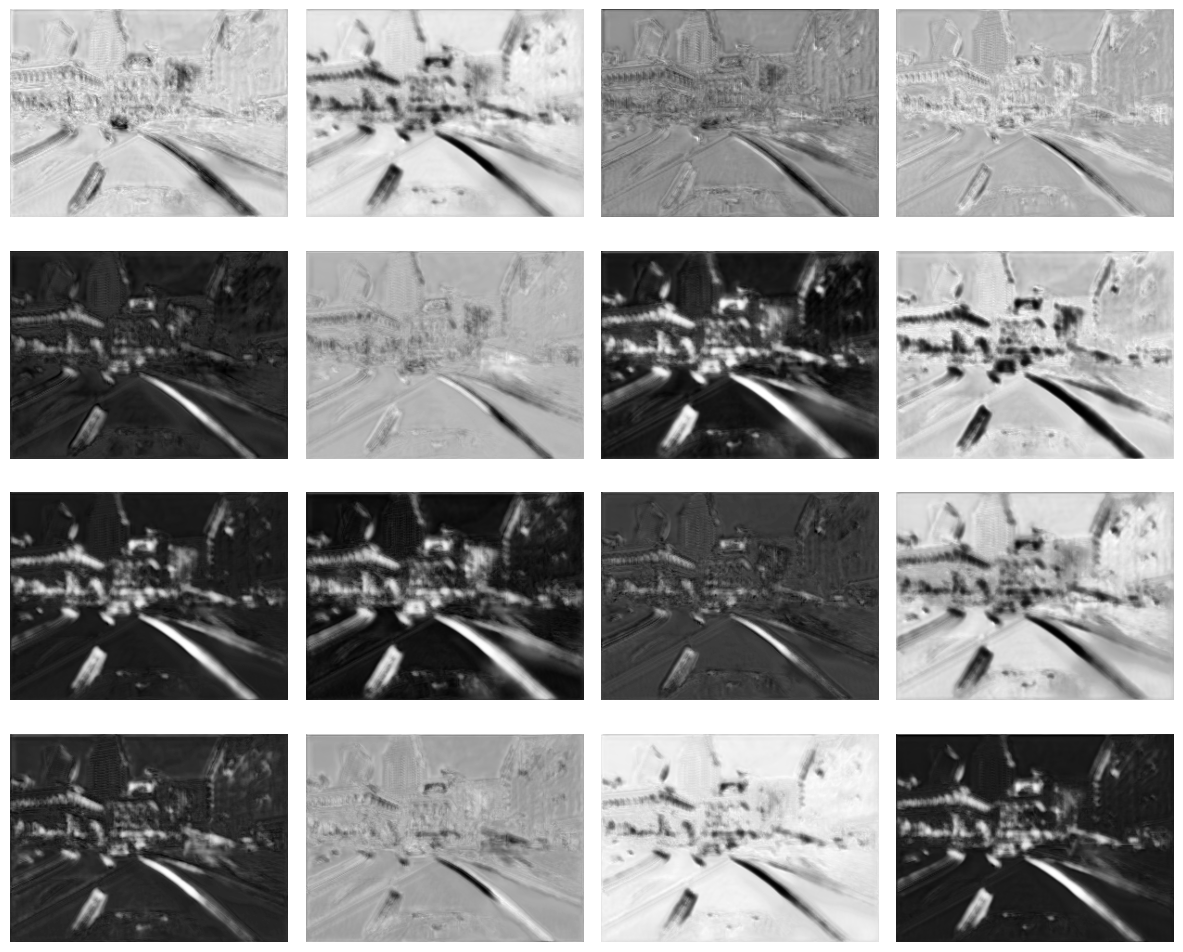

In [158]:
fig, axs = plt.subplots(4, 4, figsize=(12, 10))
# cmaps = ['Greys','Purples','Blues','Greens','Oranges','BuPu','hot','RdPu','GnBu','PuBu','YlGnBu','YlOrBr','YlOrRd','PuRd','PuBuGn','BuGn','YlGn','Wistia']
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(features_q[0, i].detach().cpu(),cmap='gray')
    # cb = axs.imshow(saliency_0[0, 0].squeeze().cpu(), cmap='gray')
    # divider = make_axes_locatable(axs)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()
fig.savefig('report/features_example.png', dpi=500)

In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

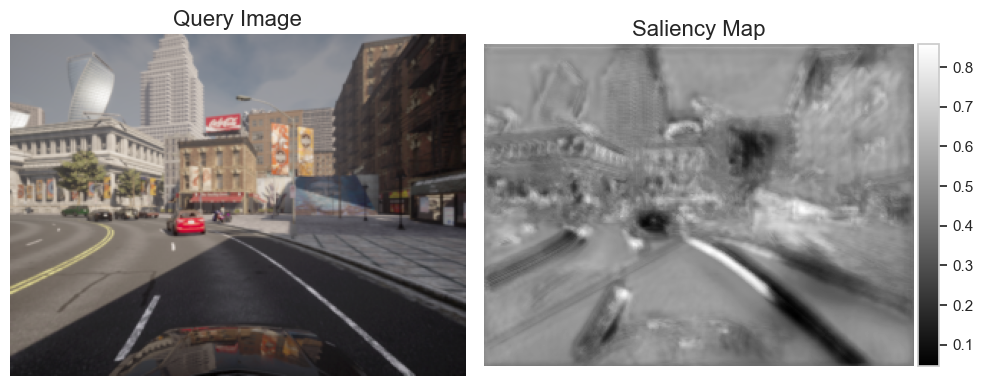

In [99]:
# plt.imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(), cmap='gray')
#show saliency and query image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(image_q[0].permute(1,2,0).cpu())
axs[0].axis('off')
axs[0].set_title('Query Image', fontsize=16)
cb = axs[1].imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
axs[1].axis('off')
axs[1].set_title('Saliency Map', fontsize=16)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
plt.tight_layout()
# plt.savefig('report/saliency_example.png', dpi=400)

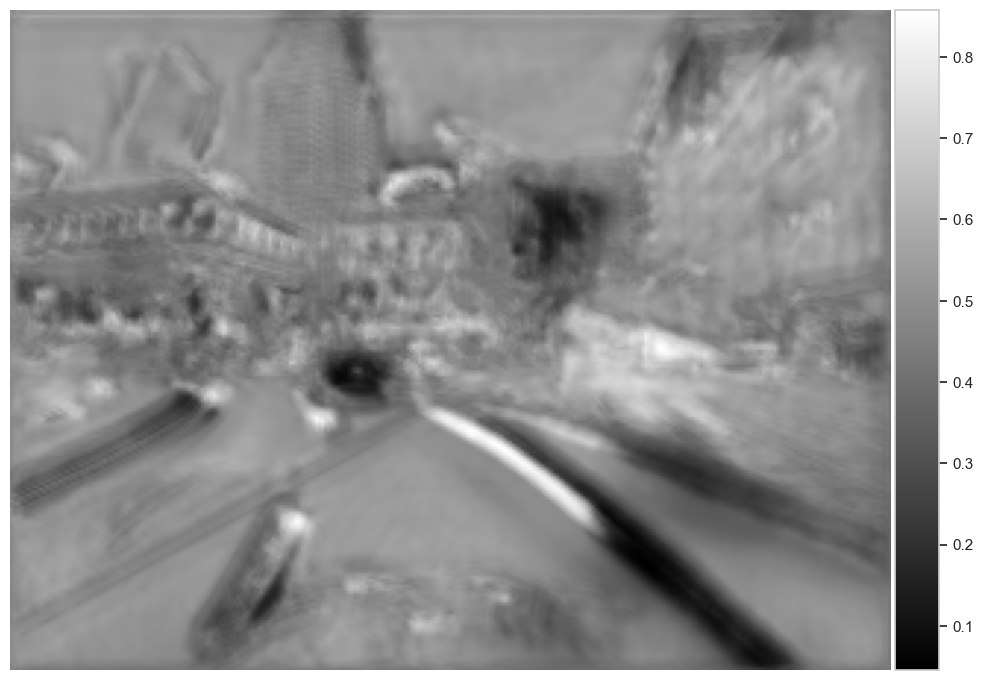

In [161]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
cb = axs.imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
axs.axis('off')
# axs.set_title('Saliency Map', fontsize=22)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
plt.tight_layout()
# plt.savefig('report/saliency_example.png', dpi=300)

In [177]:
mask_3_channel.shape,saliency_q[0,0].shape

(torch.Size([675, 300]), torch.Size([225, 300]))

In [179]:

torch.cat([saliency_q[0, 0].squeeze(0).detach(),saliency_q[0,0].squeeze(0).detach(),saliency_q[0,0].squeeze(0).detach()],dim=0).shape

torch.Size([675, 300])

In [183]:
torch.cat([saliency_q[0],saliency_q[0],saliency_q[0]]).shape

torch.Size([3, 225, 300])

In [91]:
# Overlay saliency map with query image, in each channel
mask_3_channel = torch.cat([saliency_q[0],saliency_q[0],saliency_q[0]])
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.axis('off')
# axs.imshow(image_q[0].permute(1,2,0).cpu())
# axs.imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray', alpha=0.7)
# axs.imshow((image_q[0].detach().cpu().numpy()*mask_3_channel.detach().cpu().numpy()).permute(1,2,0))
axs.imshow((image_q[0].permute(1,2,0).cpu()).numpy()*( mask_3_channel.detach().cpu().permute(1,2,0)).numpy())
plt.tight_layout()
# plt.savefig('report/saliency_overlay.png', dpi=300)

NameError: name 'saliency_q' is not defined

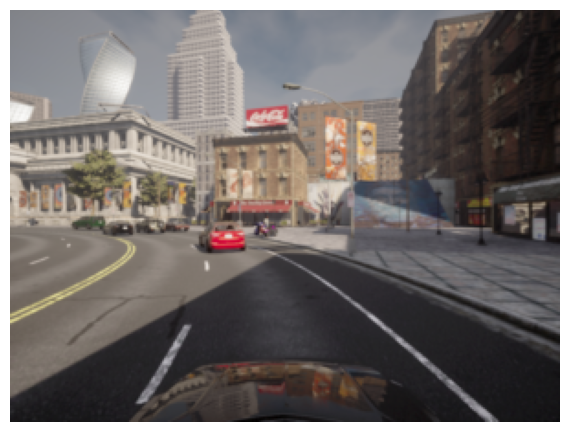

In [111]:
plt.imshow(image_q[0].permute(1,2,0).cpu())
plt.tight_layout()
plt.axis('off')
plt.savefig('report/query_example.png', dpi=300)

Same image at different time

In [128]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.unsqueeze(0).to(device)
    for x in test_rain_dynamics[21])
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
#     x.unsqueeze(0).to(device)
#     for x in test_oli[0])
translation_est = get_transforms(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10)
resampled_image = resample(depth_q.double(), K.double(), torch.linalg.inv(translation_est.double()), image_q.double())


translation error: tensor(0.1098, device='cuda:0', dtype=torch.float64) rotation error: tensor(0.0043, device='cuda:0', dtype=torch.float64)


In [129]:
resample_gt = resample(depth_q.double(), K.double(),torch.linalg.inv(transform_0q.double()), image_q.double())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.0, 1.0, 0.0, 1.0)

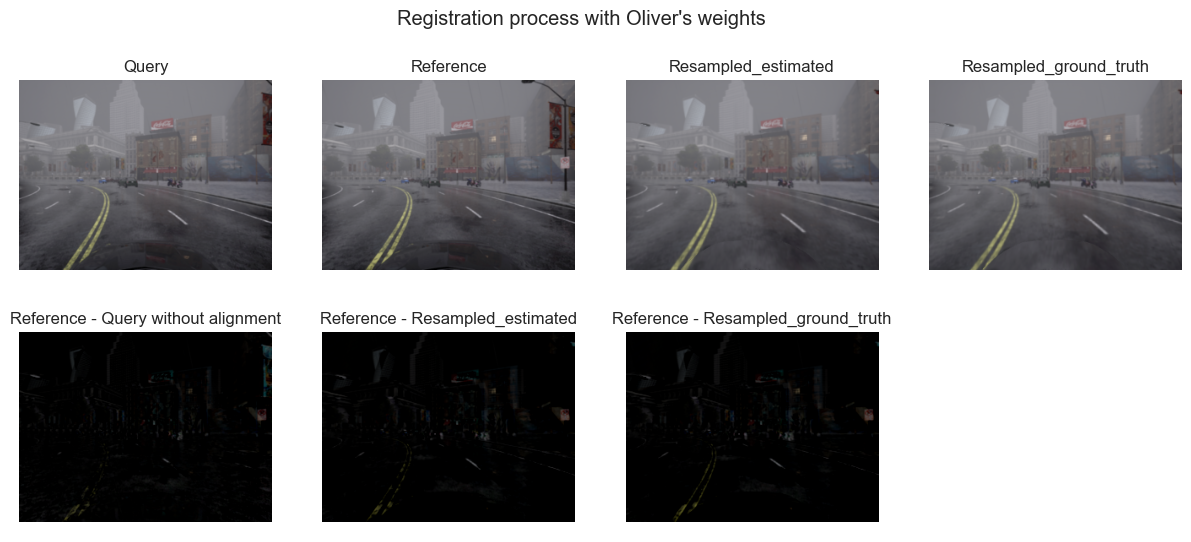

In [130]:
fig_single, ax_single = plt.subplots(2,4, figsize=(15,6))
fig_single.suptitle('Registration process with Oliver\'s weights')
ax_single[0,0].set_title('Query')
ax_single[0,1].set_title('Reference')
ax_single[0,2].set_title('Resampled_estimated')
ax_single[0,3].set_title('Resampled_ground_truth')
ax_single[1,0].set_title('Reference - Query without alignment')
ax_single[1,1].set_title('Reference - Resampled_estimated')
ax_single[1,2].set_title('Reference - Resampled_ground_truth')

ax_single[0,0].imshow(image_q[0].permute(1,2,0).cpu())
ax_single[0,0].axis('off')
ax_single[0,1].imshow(image_0[0].permute(1,2,0).cpu())
ax_single[0,1].axis('off')
ax_single[0,2].imshow(resampled_image[0].permute(1,2,0).cpu())
ax_single[0,2].axis('off')
ax_single[0,3].imshow(resample_gt[0].permute(1,2,0).cpu())
ax_single[0,3].axis('off')
ax_single[1,0].imshow((image_0[0] - image_q[0]).permute(1,2,0).cpu())
ax_single[1,0].axis('off')
ax_single[1,1].imshow((image_0[0] - resampled_image[0]).permute(1,2,0).cpu())
ax_single[1,1].axis('off')
ax_single[1,2].imshow((image_0[0] - resample_gt[0]).permute(1,2,0).cpu())
ax_single[1,2].axis('off')
ax_single[1,3].axis('off')


In [131]:
pyramid_q = net.forward(image_q.to(device))
features_q, saliency_q = pyramid_q[-1]

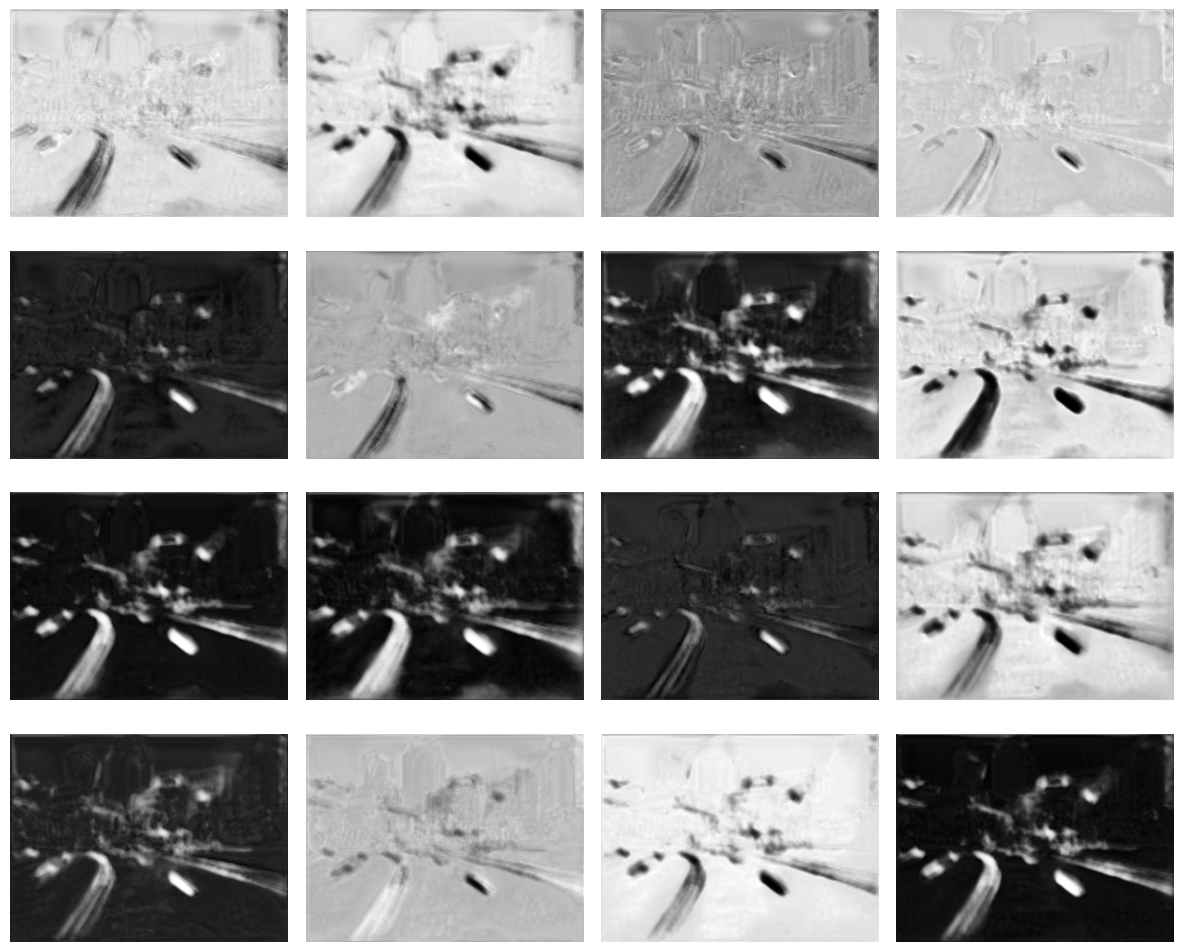

In [135]:
fig, axs = plt.subplots(4, 4, figsize=(12, 10))
# cmaps = ['Greys','Purples','Blues','Greens','Oranges','BuPu','hot','RdPu','GnBu','PuBu','YlGnBu','YlOrBr','YlOrRd','PuRd','PuBuGn','BuGn','YlGn','Wistia']
for i, ax in enumerate(axs.ravel()):
    ax.axis('off')
    ax.imshow(features_q[0, i].detach().cpu(),cmap='gray')
    # cb = axs.imshow(saliency_0[0, 0].squeeze().cpu(), cmap='gray')
    # divider = make_axes_locatable(axs)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(cb, cax=cax)

plt.tight_layout()
plt.show()
fig.savefig('report/features_example2.png', dpi=500)

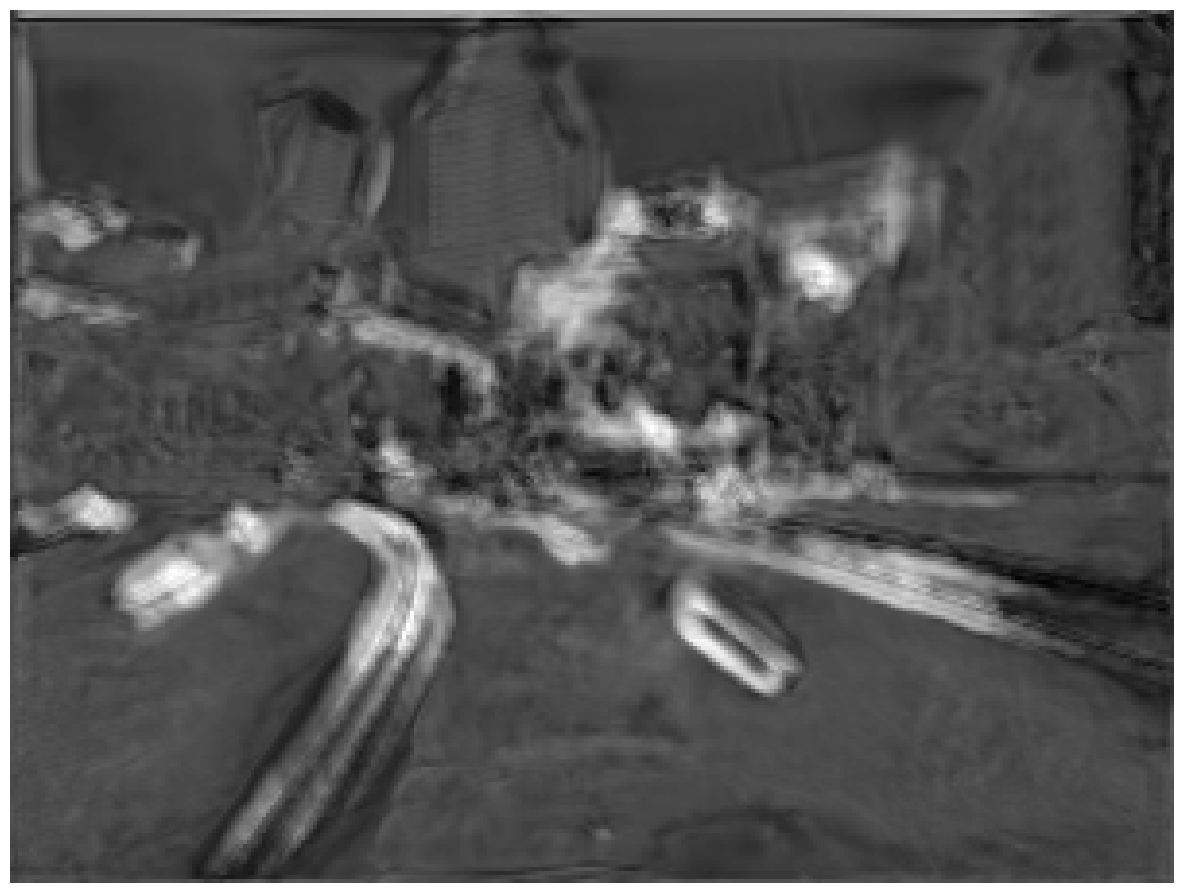

In [134]:
# add feature maps together, show grey scale
result = torch.zeros(features_q.shape, device=device)
result = torch.sum(features_q, dim=1)
for i in range(16):
    result += features_q[0, i]
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
axs.axis('off')
axs.imshow(result[0].detach().cpu()/16,cmap='gray')
plt.tight_layout()

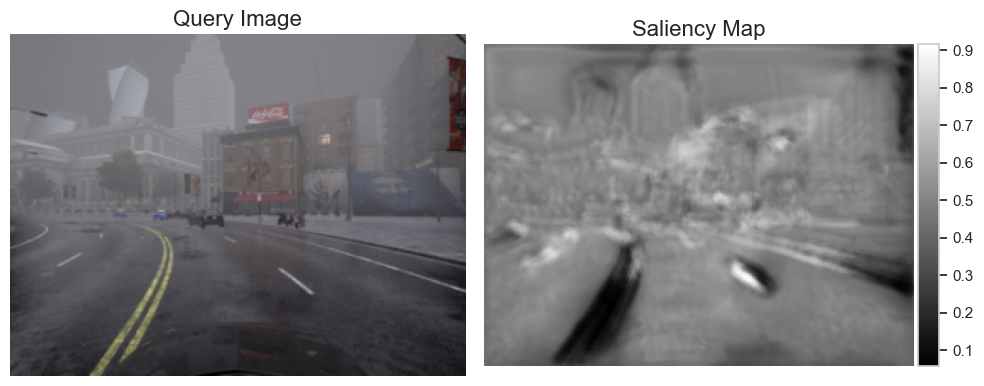

In [136]:
# plt.imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(), cmap='gray')
#show saliency and query image side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(image_q[0].permute(1,2,0).cpu())
axs[0].axis('off')
axs[0].set_title('Query Image', fontsize=16)
cb = axs[1].imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
axs[1].axis('off')
axs[1].set_title('Saliency Map', fontsize=16)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
plt.tight_layout()
plt.savefig('report/saliency_example2.png', dpi=400)

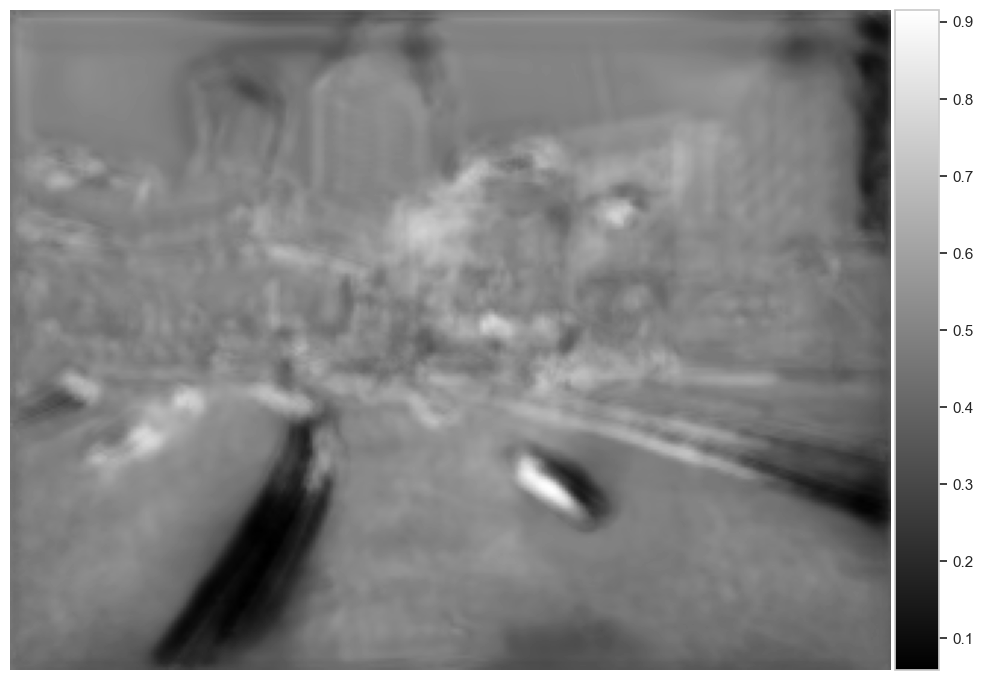

In [139]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
cb = axs.imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
axs.axis('off')
# axs.set_title('Saliency Map', fontsize=22)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
plt.tight_layout()
plt.savefig('report/saliency_example2.png', dpi=300)

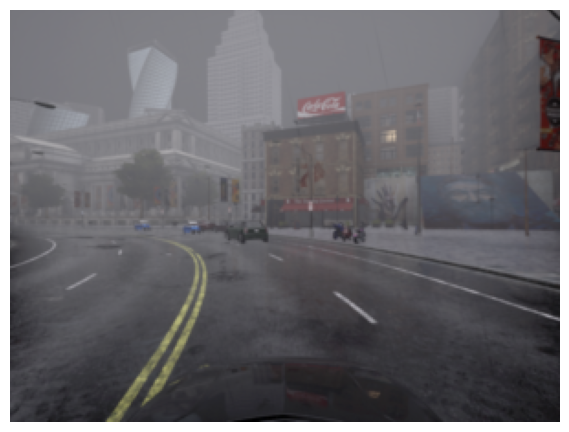

In [138]:
plt.imshow(image_q[0].permute(1,2,0).cpu())
plt.tight_layout()
plt.axis('off')
plt.savefig('report/query_example2.png', dpi=300)

Test high errors' situation 


<!-- data = [all_sd_rotation_error_list,  all_rd_rotation_error_list, all_snd_rotation_error_list,all_rnd_rotation_error_list] -->

In [72]:

# data = [all_sd_rotation_error_list,  all_rd_rotation_error_list, all_snd_rotation_error_list,all_rnd_rotation_error_list]

# find top 3 errors' index for each method
top3_sd = np.argsort(all_sd_rotation_error_list)[:3]
top3_sd

array([21,  0, 17], dtype=int64)

In [117]:
# show test images 

In [85]:
# K, transform_0q, image_0, image_q, depth_0, depth_q = test_sunny_dynamics[top3_sd[0]]
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.unsqueeze(0).to(device)
    # for x in test_sunny_dynamics[17])
    for x in test_sunny_nodynamics[17])
    # for x in test_rain_nodynamics[77])
    # for x in test_rain_dynamics[40])

(-0.5, 219.5, 189.5, -0.5)

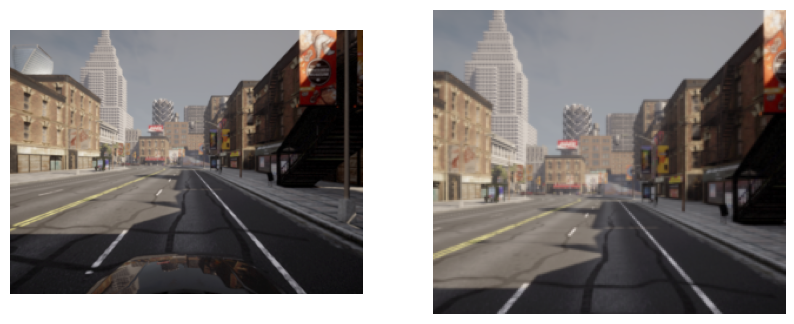

In [86]:
# plt.imshow(image_q[0].permute(1,2,0).cpu())
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(image_q[0].permute(1,2,0).cpu())
ax[0].axis('off')
ax[1].imshow(image_q[0][...,0:190,40:260].permute(1,2,0).cpu())
ax[1].axis('off')

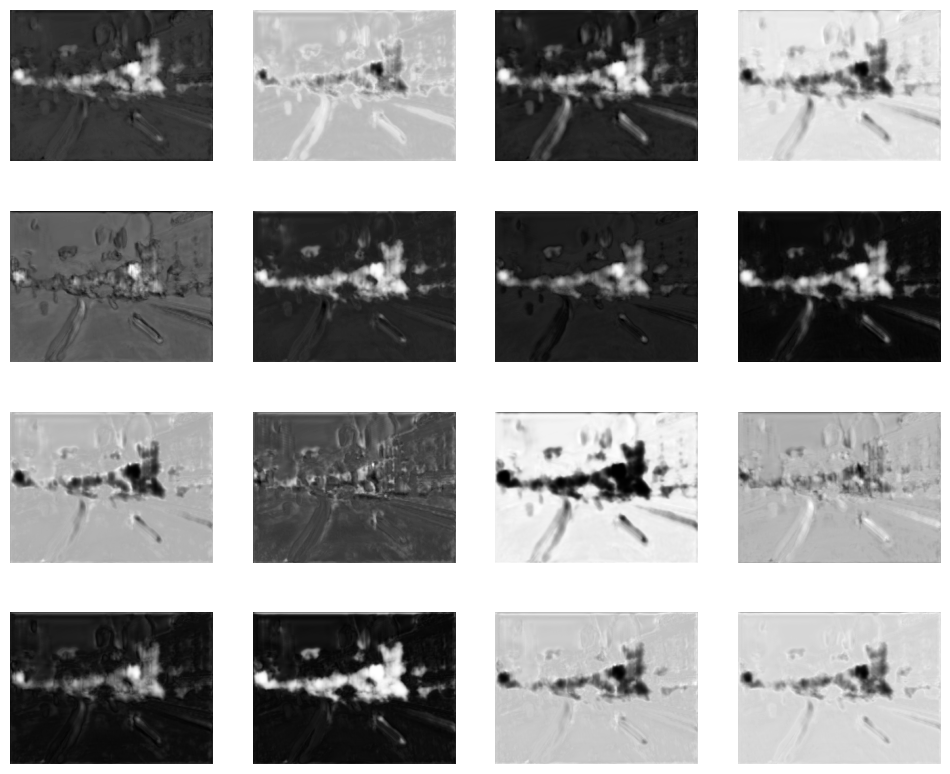

In [123]:
# featuremap and saliency map of the query image
pyramid_q = net.forward(image_q.to(device))
features_q, saliency_q = pyramid_q[-1]
# show feature maps 
fig, axs = plt.subplots(4, 4, figsize=(12, 10))
for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(features_q[0, i].detach().cpu(),cmap='gray')

(-0.5, 299.5, 224.5, -0.5)

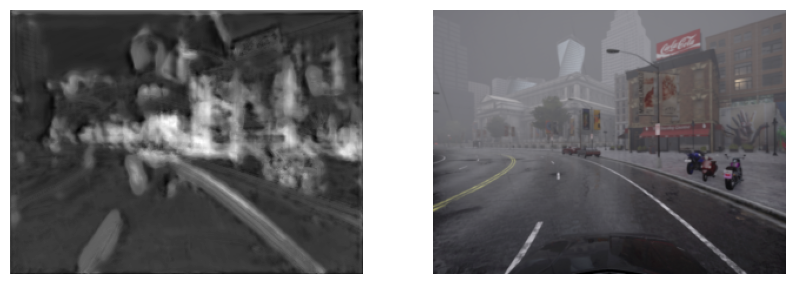

In [101]:
# show saliency map
# fig, axs = plt.subplots(1, 1, figsize=(10, 8))
# axs.axis('off')
# cb = axs.imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
ax[0].axis('off')
ax[1].imshow(image_q[0].permute(1,2,0).detach().cpu().numpy(),cmap='gray')
ax[1].axis('off')

(-0.5, 299.5, 224.5, -0.5)

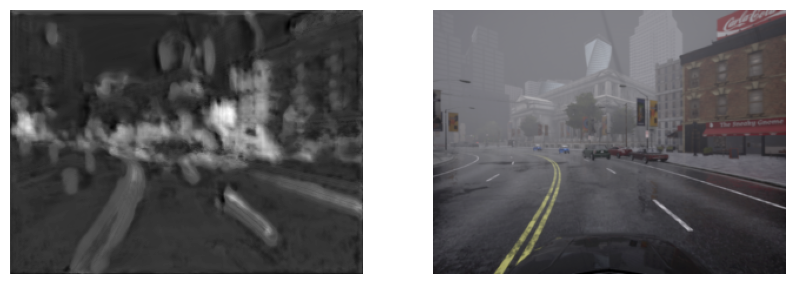

In [124]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
ax[0].axis('off')
ax[1].imshow(image_q[0].permute(1,2,0).detach().cpu().numpy(),cmap='gray')
ax[1].axis('off')

In [93]:
net.load_state_dict(torch.load('checkpoints/fyp_test_final/checkpoint24.pth'))

<All keys matched successfully>

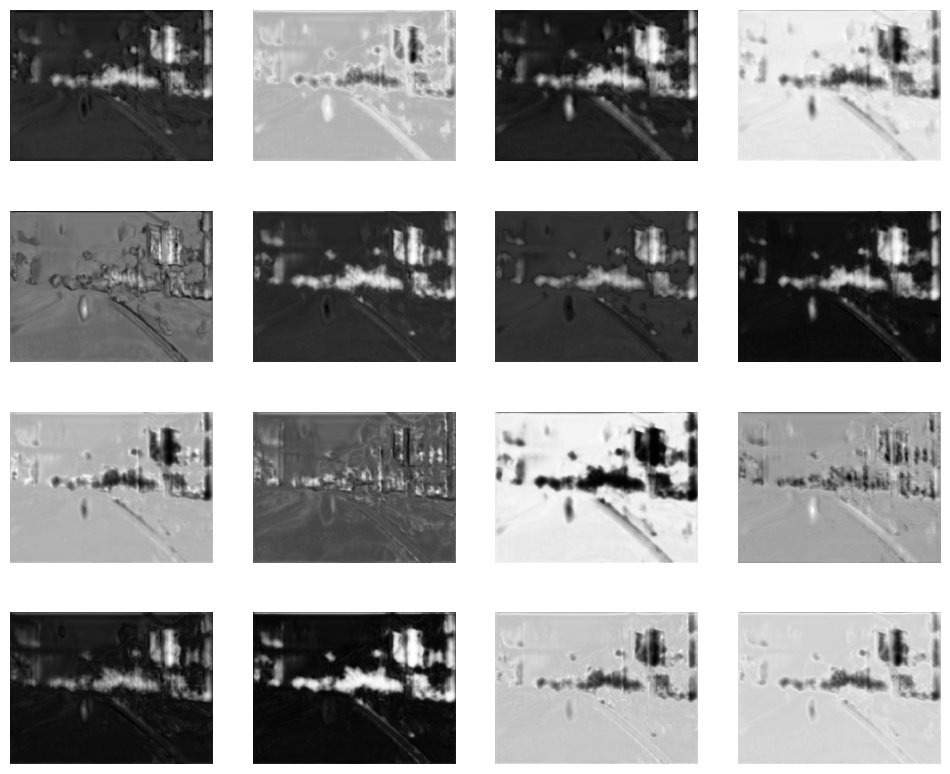

In [94]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.unsqueeze(0).to(device)
    # for x in test_sunny_dynamics[21])
    for x in test_rain_nodynamics[92])
# show feature map and saliency map
pyramid_q = net.forward(image_q.to(device))
features_q, saliency_q = pyramid_q[-1]
# show feature maps
fig, axs = plt.subplots(4, 4, figsize=(12, 10))
for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(features_q[0, i].detach().cpu(),cmap='gray')


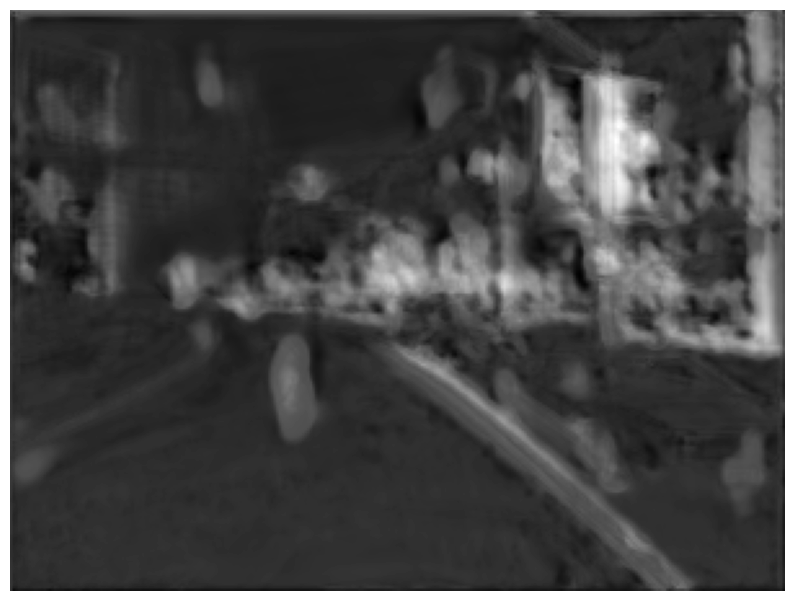

In [95]:
# show saliency map
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.axis('off')
cb = axs.imshow(saliency_q[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')

### compare the saliency maps from both networks on a case where there are no dynamic objects?

In [163]:
# load trianing set
train_sd  = np.load('train_sunny_dynamics_404.npz')
train_snd = np.load('train_sunny_noDynamics_404.npz')


In [167]:
ds_train_sd = CarlaTriplesDataset(train_sd)
ds_train_snd = CarlaTriplesDataset(train_snd)

tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])
tensor([[400.,   0., 400.],
        [  0., 400., 300.],
        [  0.,   0.,   1.]])


(-0.5, 799.5, 599.5, -0.5)

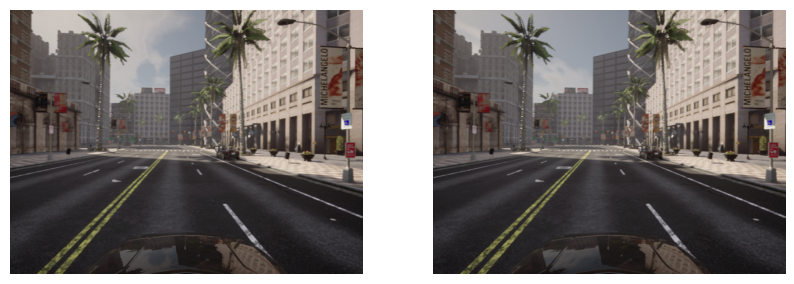

In [166]:
# show 1st images 
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(train_sd['rgbs'][5])
ax[0].axis('off')
ax[1].imshow(train_snd['rgbs'][5])
ax[1].axis('off')

In [168]:
# find saliency maps for training images
# K, transform_0q, image_0, image_q, depth_0, depth_q = test_sunny_dynamics[top3_sd[0]]
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.unsqueeze(0).to(device)
    for x in ds_train_sd[5])

# featuremap and saliency map of the query image
pyramid_q1 = net.forward(image_q.to(device))
features_q1, saliency_q1 = pyramid_q1[-1]
# show feature maps 
# fig, axs = plt.subplots(4, 4, figsize=(12, 10))
# for i in range(16):
#     axs[i//4, i%4].axis('off')
#     axs[i//4, i%4].imshow(features_q[0, i].detach().cpu(),cmap='gray')
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10 = (
    x.unsqueeze(0).to(device)
    for x in ds_train_snd[5])
pyramid_q2 = net.forward(image_q.to(device))
features_q2, saliency_q2 = pyramid_q1[-1]
    

(-0.5, 299.5, 224.5, -0.5)

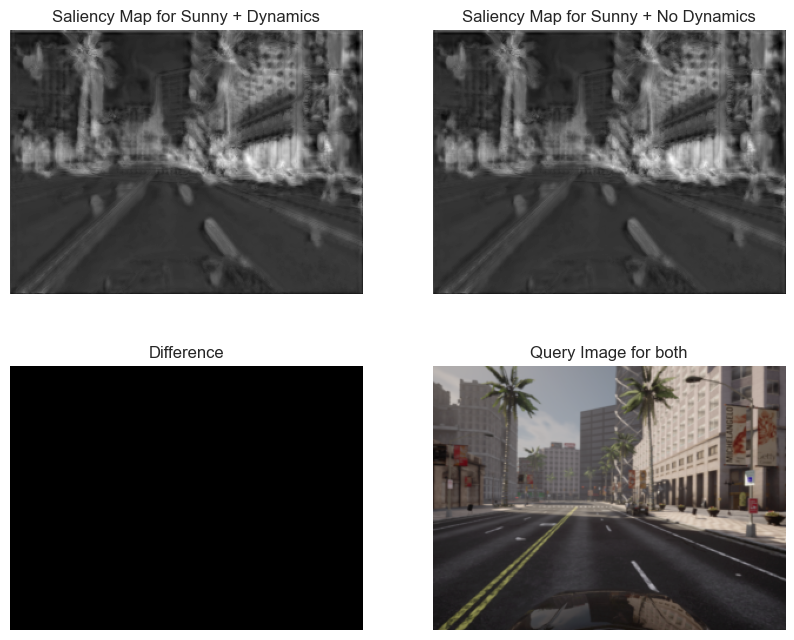

In [174]:
# show saliency maps 
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(saliency_q1[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(saliency_q2[0, 0].squeeze().detach().cpu().numpy(),cmap='gray')
ax[0,1].axis('off')
ax[0,0].set_title("Saliency Map for Sunny + Dynamics")
ax[0,1].set_title("Saliency Map for Sunny + No Dynamics")
ax[1,0].imshow((saliency_q1-saliency_q2)[0,0].squeeze().detach().cpu().numpy(),cmap='gray')
ax[1,0].axis('off')
ax[1,0].set_title("Difference")
ax[1,1].set_title("Query Image for both")
ax[1,1].imshow(image_q[0].permute(1,2,0).detach().cpu().numpy(),cmap='gray')
ax[1,1].axis('off')

In [ ]:
# calcuate average baseline:



In [177]:
def baseline(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10):
    # result_0q = torch.zeros(len(K.double()), 6, device=device) # params_from_transform(transform_q0) # 
    result_0q = torch.zeros(len(K), 6, device=device)
    # with torch.no_grad():
    #     pyramid_q = net.forward(image_q.to(device))
    #     pyramid_0 = net.forward(image_0.to(device))
    # levels = [0, 1, 2, 3]
    # iterations = [16, 12, 8, 4]
    # for level in levels:
    #     features_q, saliency_q = pyramid_q[level]
    #     features_0, saliency_0 = pyramid_0[level]
            
    #     # Resample depth maps for pyramid
    #     size = features_q.shape[-2:]
    #     depth_0_ = torchvision.transforms.functional.resize(depth_0, size).to(device).unsqueeze(0)

    #     # Align image_0 to query image
    #     image_0_optimizer = GaussNewtonFeatureOptimizer(K.double(), features_0.double(), saliency_0.double(), depth_0_.double())
    #     result_0q = image_0_optimizer.forward(result_0q.double(), features_q.double(), saliency_q.double(), iterations=iterations[level])
        
    #     # print(result_0q)
    #     # image_0_optimizer = GaussNewtonFeatureOptimizer(K, features_0, saliency_0, depth_0_)
    #     # result_0q = image_0_optimizer.forward(result_0q.float(), features_q.float(), saliency_q.float(), iterations[level])
    # transform_0q_est = transform_from_params(result_0q.double())
    # # transform_0q_est = transform_from_params(result_0q)
    transform_0q_est = transform_from_params(result_0q.double())
    rotation_error, translation_error = errors(transform_0q_est, transform_0q)

    return rotation_error, translation_error
def baseline_dataloader(dataloader):
    progress = tqdm.tqdm(dataloader)
    translation_error_list = np.zeros(len(dataloader))
    rotation_error_list = np.zeros(len(dataloader))
    for batch_idx, batch in enumerate(progress):
        K, image_q, image_0, image_1, depth_q, depth_0, depth_1,  transform_0q, transform_1q, transform_10 = (
            x.to(device)
            for x in batch
        )
        rotation_error, translation_error = test(K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_0q, transform_1q, transform_10)
        translation_error_list[batch_idx] = translation_error.item()
        rotation_error_list[batch_idx] = rotation_error.item()
    max_10_translation_error = np.argsort(translation_error_list)[-10:]
    max_10_rotation_error = np.argsort(rotation_error_list)[-10:]
    mean_translation_error = np.mean(translation_error_list)
    mean_rotation_error = np.mean(rotation_error_list)
    var_translation_error = np.var(translation_error_list)
    var_rotation_error = np.var(rotation_error_list)
    # max_translation_error_images = [image_q[max_10_translation_error], image_0[max_10_translation_error], image_1[max_10_translation_error]]
    # max_rotation_error_images = [image_q[max_10_rotation_error], image_0[max_10_rotation_error], image_1[max_10_rotation_error]]
    # return translation_error_list, rotation_error_list, np.mean(translation_error_list), np.mean(rotation_error_list),max_10_translation_error, max_10_rotation_error
    return translation_error_list, rotation_error_list
    

In [178]:
baseline_sd_t,baseline_sd_r = baseline_dataloader(dataloader_sunny_dynamics_matched)
baseline_snd_t,baseline_snd_r = baseline_dataloader(dataloader_sunny_nodynamics_matched)

100%|██████████| 28/28 [00:53<00:00,  1.92s/it]


In [181]:
average_baseline_sd_t = np.mean(baseline_sd_t)
average_baseline_sd_r = np.mean(baseline_sd_r)
average_baseline_snd_t = np.mean(baseline_snd_t)
average_baseline_snd_r = np.mean(baseline_snd_r)


In [182]:
average_baseline_sd_r, average_baseline_sd_t, average_baseline_snd_r, average_baseline_snd_t

(0.31610548610238237,
 0.004491066455570077,
 0.15769128745474323,
 0.003517308738273917)

tensor([[[ 9.9747e-01, -2.1326e-03, -7.0991e-02,  9.9050e-02],
         [ 2.1768e-03,  1.0000e+00,  5.4578e-04, -2.1583e-03],
         [ 7.0990e-02, -6.9894e-04,  9.9748e-01, -2.0481e-01],
         [ 5.5642e-19,  1.0337e-20,  5.2278e-18,  1.0000e+00]]],
       device='cuda:0')

In [186]:
errors (transform_0q,torch.eye(4).to(device))

(tensor(0.2276, device='cuda:0', dtype=torch.float64),
 tensor(0.0711, device='cuda:0', dtype=torch.float64))